In [12]:
import transformers
from transformers import XLNetTokenizer, XLNetModel
from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.manifold import TSNE
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight


import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from tqdm import tqdm
from scipy.stats import spearmanr
import mplcursors
import time
import random
import pandas as pd
import numpy as np
import warnings
import re


seed = 42

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

random.seed(seed)
np.random.seed(seed)


In [40]:
import ast
Gene2Vec = dict()

file_path = f'data/gene2vec_embeddings.txt'
with open(file_path, 'r') as file:
    for line in file:
        
        g_name, g_embed = line.strip().split("	")
        g_embed = [float(value) for value in g_embed.split()] 
        
        Gene2Vec[g_name.strip()] = g_embed


        
knownGenes = []
for i in range (14):
    file_path = f'data/knownGenes/GeneLLM_all_cluster{i}.txt'
    with open(file_path, 'r') as file:
        for line in file:
            knownGenes.append(line.strip())

c=0
for g in knownGenes:
    if g in Gene2Vec.keys():
        c +=1
        
c, len(knownGenes)

(14083, 15778)

In [13]:
class FineTunedBERT(nn.Module):

    def __init__(self, pool="mean", model_name= "bert-base-cased",
                 task ="reg", n_labels = 3, drop_rate = 0.1, gene2vec_hidden = 200):
        """
            task : reg (regression) or class(classification).
        
        """
      
        super(FineTunedBERT, self).__init__()
        
        if "xlnet" in model_name:
            self.bert = XLNetModel.from_pretrained(model_name)
        
        else:
            self.bert = AutoModel.from_pretrained(model_name)
        
        self.pool = pool
        bert_hidden = self.bert.config.hidden_size
        
        
        if task.lower() == "reg":
            self.pipeline = nn.Sequential(
                nn.Linear(bert_hidden, 1))
            
        elif task.lower() == "class":

            self.pipeline = nn.Sequential(
                nn.Linear(bert_hidden, n_labels)
            
            )
        elif task.lower() == "sub_gene2vec":
            #BERT + Gene2Vec 968 -> 512 -> n_labels
            self.pipeline = nn.Sequential(
                nn.Linear(bert_hidden+gene2vec_hidden, n_labels),
#                 nn.ReLU(),            
#                 nn.Dropout(drop_rate),
#                 nn.Linear(512, n_labels)
            )
            
        else:
            raise ValueError(f"Key Error [task] : {task} ")

            
        
        
    def forward(self, input_ids_, attention_mask_, gene2vec=None):
        
        #pass the inputs to the model
        
        # text -> tokenizer -> input_ids(maxlen x 1), attention_mask(maxlen x 1) -> BERT -> 
        
        # maxlen x 1
        # maxlen x 1
        
        
        if "xlnet" in model_name:
            hiddenState = list(self.bert(input_ids = input_ids_,
                                         attention_mask=attention_mask_).values())[0]
        
        else:
            hiddenState, ClsPooled = self.bert(input_ids = input_ids_,
                                               attention_mask=attention_mask_).values()

        
        
    
        
        
        # maxlen x 768
        
        
        
        if self.pool.lower() == "max":
            embeddings = self.max_pooling(hiddenState, attention_mask_)
            
        elif self.pool.lower() == "cls":
            
            if "xlnet" in model_name:
                embeddings = hiddenState[0]
            else:
                embeddings = ClsPooled
                
        elif self.pool.lower() == "mean":
            embeddings = self.mean_pooling(hiddenState, attention_mask_)

        else:
            raise ValueError('Pooling value error.')
            
        
        # 1 x 768 -> geneEmbedding
        
        
        
        if gene2vec is not None:
            embeddings = torch.cat((embeddings, gene2vec), dim=1) 
      
        
        # 1 x (768+200)  -> geneEmbedding
        
        return embeddings, hiddenState, self.pipeline(embeddings)

    def max_pooling(self, hidden_state, attention_mask):
        
        #CLS: First element of model_output contains all token embeddings
        token_embeddings = hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
        
        pooled_embeddings = torch.max(token_embeddings, 1)[0]
        return pooled_embeddings
    
    def mean_pooling (self, hidden_state, attention_mask):
        
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_state.size()).float()
        pooled_embeddings = torch.sum(hidden_state * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9) 
        
        return pooled_embeddings


In [6]:
def process_sent(sent):

    pattern1 = r'(?:"(.*?)"|\'(.*?)\')'
    pattern2 = r"\[provided by .*?\]"
    pattern3 = r"\(PubMed:\d+(?:\s+\d+)*\)"
    pattern4 = r"\(\s+[\w\s]+\s+[\w]+\s+\)"
    pattern5 = r"\s*\(Microbial infection\)"
    pattern6 = r"\[(Isoform [^\]]+)\]:\s*"
    pattern7 = r"\(By similarity\)"

    matches = re.findall(pattern1, sent)
    captured_content = [match[0] if match[0] else match[1] for match in matches]
    text = " ".join(captured_content)
    text = re.sub(pattern2, "", text)
    text = re.sub(pattern3, "####", text)
    text = re.sub(pattern4, "", text)
    text = re.sub(pattern5, "", text)
    text = re.sub(pattern6, r"\1 ", text)
    text = re.sub(pattern7, "", text)
    text = re.sub(r'\s+', ' ', text)
    
    return text
    

def getSentenceEmbeddings(sentences, max_length=512, batch_size=1000, pool ="mean"):
    
    

    model = FineTunedBERT(pool= pool)
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

    print("Perform tokenization ...")
    tokens = tokenizer.batch_encode_plus(sentences, max_length = max_length,
                                         padding="max_length",truncation=True,
                                         return_tensors="pt")
    
    
    dataset = TensorDataset(tokens["input_ids"] , tokens["attention_mask"])
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    print("Tokenization Done.")
    
    print("Get embeddings ...")
    
    embeddings=[]
    model.eval()
    for batch_input_ids, batch_attention_mask in tqdm(dataloader):
        with torch.no_grad():
            pooled_embeddings, _, _ = model(batch_input_ids , batch_attention_mask)
            embeddings.append(pooled_embeddings)
    
    
    concat_embeddings = torch.cat(embeddings, dim=0)
    
    print(concat_embeddings.size())
    
    return concat_embeddings
    

In [3]:
knownGenes = []
for i in range (14):
    file_path = f'data/knownGenes/GeneLLM_all_cluster{i}.txt'
    with open(file_path, 'r') as file:
        for line in file:
            knownGenes.append(line.strip()) 


genes = pd.read_csv("data/genes.csv")
genes["Summary"] = genes["Summary"].apply(lambda sent: process_sent(sent))
genes = genes.drop_duplicates(subset='Summary')
genes = genes[genes['Gene name'].isin(knownGenes)].reset_index(drop=True)
genes

NameError: name 'process_sent' is not defined

### Conservation Data

In [84]:
def plot_latent(latents, epoch, validation_type="train"):
    
    tsne = TSNE(n_components=2)
    scaler = StandardScaler()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        latents_tsne = tsne.fit_transform(latents)
    
    
    plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1])
    
    plt.title(f'Epoch {epoch}')
    plt.savefig(f"saved-figures/latent/{validation_type}/latent_{epoch}.png")
    plt.close()


def train(loader, model, optimizer):
    
    
    train_loss = 0
    latents  = []
    total_preds = []
    total_labels = []
    total_corr = 0
    MSELoss = nn.MSELoss()
    
    model.train()
    for batch in tqdm(loader): 

        batch_inputs, batch_masks, batch_labels =  batch[0].to("cuda") , batch[1].to("cuda"), batch[2].to("cuda")

        
        pooled_embeddings, _ , preds = model(batch_inputs, batch_masks)

        preds = preds.squeeze().float()
        labels = batch_labels.squeeze().float()
        loss = MSELoss(preds, labels)
        
        total_corr += spearmanr(preds.cpu().detach(), labels.cpu().detach())[0]
        train_loss += loss.item()

        
        #Aggregation
        pooled_embeddings = torch.tensor(pooled_embeddings.cpu().detach().numpy())
        latents.append(pooled_embeddings) 
        total_preds.extend(preds.cpu().detach())
        total_labels.extend(labels.cpu().detach())

            
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(loader)
    total_corr /= len(loader)
    latents = torch.cat(latents, dim=0)

#     print(f"total_corr:{spearmanr(total_preds, total_labels)[0]}")
#     print(f"batch_corr:{total_corr}")
    
                
    return model, train_loss, total_corr,  latents




def validation (loader, model):
    
    val_loss = 0
    total_corr = 0
    MSELoss = nn.MSELoss()
    
    model.eval()
    for batch in tqdm(loader): 

        batch_inputs, batch_masks, batch_labels =  batch[0].to("cuda") , batch[1].to("cuda"), batch[2].to("cuda")

        
        pooled_embeddings, _ , preds = model(batch_inputs, batch_masks)

        preds = preds.squeeze().float()
        labels = batch_labels.squeeze().float()
        loss = MSELoss(preds, labels)
        
        total_corr += spearmanr(preds.cpu().detach(), labels.cpu().detach())[0]
        
        val_loss += loss.item()

    
    val_loss /= len(loader)
    total_corr /= len(loader)
    

                
    return model, val_loss, total_corr


def test(loader, model):
    
    test_loss = 0
    total_corr = 0
    MSELoss = nn.MSELoss()
    latents = []
    model.eval()
    
    for batch in tqdm(loader): 

        batch_inputs, batch_masks, batch_labels =  batch[0].to("cuda") , batch[1].to("cuda"), batch[2].to("cuda")

        
        pooled_embeddings, _ , preds = model(batch_inputs, batch_masks)

        preds = preds.squeeze().float()
        labels = batch_labels.squeeze().float()
        loss = MSELoss(preds, labels)
        
        total_corr += spearmanr(preds.cpu().detach(), labels.cpu().detach())[0]
        
        test_loss += loss.item()

        pooled_embeddings = torch.tensor(pooled_embeddings.cpu().detach().numpy())
        latents.append(pooled_embeddings)
        
        
    test_loss /= len(loader)
    total_corr /= len(loader)
    latents = torch.cat(latents, dim=0)

                
    return model, test_loss,total_corr, latents

def process_data(genes, max_length, batch_size,
                 gene2vec_flag = False, model_name= "bert-base-cased"):
    
    tokenizer = BertTokenizerFast.from_pretrained(model_name)
    
    sentences, labels, g_names = genes["Summary"].tolist() , genes["Conservation"].tolist(), genes.index.tolist()
    
    tokens = tokenizer.batch_encode_plus(sentences, max_length = max_length, padding="max_length",
                                         truncation=True)

    data = {'input_ids': tokens["input_ids"],
            'token_type_ids': tokens["token_type_ids"],
            'attention_mask': tokens["attention_mask"],
            "labels": labels,
            "g_name": g_names
           }
    
    tokens_df = pd.DataFrame(data)
    #############################################
    if gene2vec_flag:
        print("Adding Gene2Vec data ...")
        
        Gene2Vec = dict()

        file_path = f'data/gene2vec_embeddings.txt'
        with open(file_path, 'r') as file:
            for line in file:

                g_name, g_embed = line.strip().split("	")
                g_embed = [float(value) for value in g_embed.split()] 

                Gene2Vec[g_name.strip()] = g_embed
        
        #This will not work
        tokens_df["gene2vec"] = tokens_df["g_name"].apply(lambda name: Gene2Vec[name])
    #############################################
    
    
    train_tokens, test_tokens = train_test_split(tokens_df, test_size=0.15,
                                                 random_state=42)
    
    train_tokens, val_tokens = train_test_split(train_tokens,test_size=0.20,
                                                random_state=42)

    train_tokens = train_tokens.reset_index(drop=True)
    val_tokens = val_tokens.reset_index(drop=True)
    test_tokens = test_tokens.reset_index(drop=True)
    
    train_dataset = TensorDataset(torch.tensor(train_tokens["input_ids"].tolist()),
                                  torch.tensor(train_tokens["attention_mask"].tolist()),
                                  torch.tensor(train_tokens["gene2vec"]),
                                  torch.tensor(train_tokens["labels"]),
                                  torch.tensor(train_tokens["g_name"])
                                 )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    
    
    
    val_dataset = TensorDataset(torch.tensor(val_tokens["input_ids"].tolist()) ,
                                torch.tensor(val_tokens["attention_mask"].tolist()),
                                torch.tensor(val_tokens["gene2vec"]),
                                torch.tensor(val_tokens["labels"]),
                                torch.tensor(val_tokens["g_name"])
                               )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    
    
    test_dataset = TensorDataset(torch.tensor(test_tokens["input_ids"].tolist()),
                                 torch.tensor(test_tokens["attention_mask"].tolist()),
                                 torch.tensor(test_tokens["gene2vec"]),
                                 torch.tensor(test_tokens["labels"]),
                                 torch.tensor(test_tokens["g_name"])
                                )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    return train_loader, val_loader, test_loader

def trainer(epochs, genes, lr =5e-5, pool="cls",
            max_length= 100, batch_size =100, model_name= "bert-base-cased"):
    
    
    model = FineTunedBERT(pool= pool, task = "reg").to("cuda")
    
    optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    
    train_loader, val_loader, test_loader = process_data(genes, max_length,
                                                         batch_size, gene2vec_flag = gene2vec_flag,
                                                         model_name = model_name)
    
    for epoch in range(epochs):
        start_time = time.time()
        
        print(f"Epoch {epoch+1} of {epochs}")
        print("-------------------------------")
        
        print("Training ...")
        model, train_loss, train_corr, latents = train(train_loader, model, optimizer)
        plot_latent(latents, epoch, validation_type="train")
        
        print("Validation ...")
        model, val_loss, val_corr  = validation (val_loader, model)
        
        print("Testing ...")
        model, test_loss, test_corr, _ = test (test_loader, model)
        
        print(f'\tET: {round(time.time() - start_time,2)} Seconds')
        print(f'\tTrain Loss: {round(train_loss,4)}, corrcoef: {round(train_corr,4)}')
        print(f'\tVal Loss: {round(val_loss,4)}, corrcoef: {round(val_corr,4)}')
        print(f'\tTest Loss: {round(test_loss,4)}, corrcoef: {round(test_corr,4)}')


In [7]:
#Funmi
knownGenes = []
for i in range (14):
    file_path = f'data/knownGenes/GeneLLM_all_cluster{i}.txt'
    with open(file_path, 'r') as file:
        for line in file:
            knownGenes.append(line.strip()) 

#Shane
phast = pd.read_csv("data/phastcons.csv")
labels_dict =  phast.set_index("GeneSymbol")["Conservation"].to_dict()


genes = pd.read_csv("data/genes.csv")
genes["Summary"] = genes["Summary"].apply(lambda sent: process_sent(sent))
genes = genes.drop_duplicates(subset='Summary')
genes = genes[genes['Gene name'].isin(knownGenes)]

genes["Conservation"] = genes["Gene name"].apply(lambda name: labels_dict.get(name,None))
genes_phast = genes.dropna(subset=["Conservation"]).reset_index(drop=True)

genes_phast

Gene name                                            Summary  \
0              FES  This gene encodes the human cellular counterpa...   
1           SLC7A7  The protein encoded by this gene is the light ...   
2            HSPA2  Enables disordered domain specific binding act...   
3           ZSCAN9  Enables sequence-specific double-stranded DNA ...   
4          SEPTIN3  This gene encodes a member of the sorting nexi...   
...            ...                                                ...   
14512     C19orf25  This gene encodes a T-box family member. The T...   
14513  IQCJ-SCHIP1  C19orf25 (Chromosome 19 Open Reading Frame 25)...   
14514        BPY2C  This gene is located in the nonrecombining por...   
14515         DNER  The protein encoded by this gene is a cofactor...   
14516       CXCL14  This gene encodes a member of the SOX (SRY-rel...   

                                            Interactions  Conservation  
0      Homooligomer.Interacts with BCR.Interacts (whe...      0.640952  
1                                                    NaN      0.418753  
2                                                    NaN      0.424108  
3                                                    NaN      0.090192  
4      Interacts with ATP6V1D; may play a role in cil...      0.703949  
...                                                  ...           ...  
14512  The sequence AAD21787.1 differs from that show...      0.160615  
14513                                                NaN      0.668076  
14514  Interacts with MAP1S.Interacts with UBE3A (via...      0.066946  
14515  Forms a 1:1 stoichiometric complex with pancre...      0.662750  
14516  Interacts with CTNNB1/beta-catenin; this inter...      0.606774  

[14517 rows x 4 columns]

In [68]:
import gc
torch.cuda.empty_cache()
gc.collect()

254

##### CLS pooling

In [72]:
epochs = 6
lr = 2e-5
max_length = 250
batch_size = 80
pool ="cls"

trainer(epochs, genes_phast, lr =lr, pool= pool, max_length= max_length, batch_size =batch_size)

Epoch 1 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:34<00:00,  1.31it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.06it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.12it/s]


	ET: 122.52 Seconds
	Train Loss: 0.0547, corrcoef: 0.1179
	Val Loss: 0.0369, corrcoef: 0.325
	Test Loss: 0.037, corrcoef: 0.3336
Epoch 2 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:35<00:00,  1.30it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.05it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.13it/s]


	ET: 123.04 Seconds
	Train Loss: 0.0375, corrcoef: 0.3202
	Val Loss: 0.0337, corrcoef: 0.4388
	Test Loss: 0.0334, corrcoef: 0.4467
Epoch 3 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:34<00:00,  1.31it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.07it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.15it/s]


	ET: 123.01 Seconds
	Train Loss: 0.0336, corrcoef: 0.4381
	Val Loss: 0.0323, corrcoef: 0.4767
	Test Loss: 0.0326, corrcoef: 0.4818
Epoch 4 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:34<00:00,  1.31it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.06it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.14it/s]


	ET: 122.64 Seconds
	Train Loss: 0.0306, corrcoef: 0.5078
	Val Loss: 0.0324, corrcoef: 0.4848
	Test Loss: 0.0325, corrcoef: 0.4951
Epoch 5 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:34<00:00,  1.31it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.06it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.15it/s]


	ET: 122.14 Seconds
	Train Loss: 0.0289, corrcoef: 0.5472
	Val Loss: 0.0318, corrcoef: 0.485
	Test Loss: 0.0318, corrcoef: 0.4991
Epoch 6 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:34<00:00,  1.31it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.07it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.14it/s]

	ET: 122.7 Seconds
	Train Loss: 0.0262, corrcoef: 0.6026
	Val Loss: 0.0323, corrcoef: 0.4786
	Test Loss: 0.0319, corrcoef: 0.5001


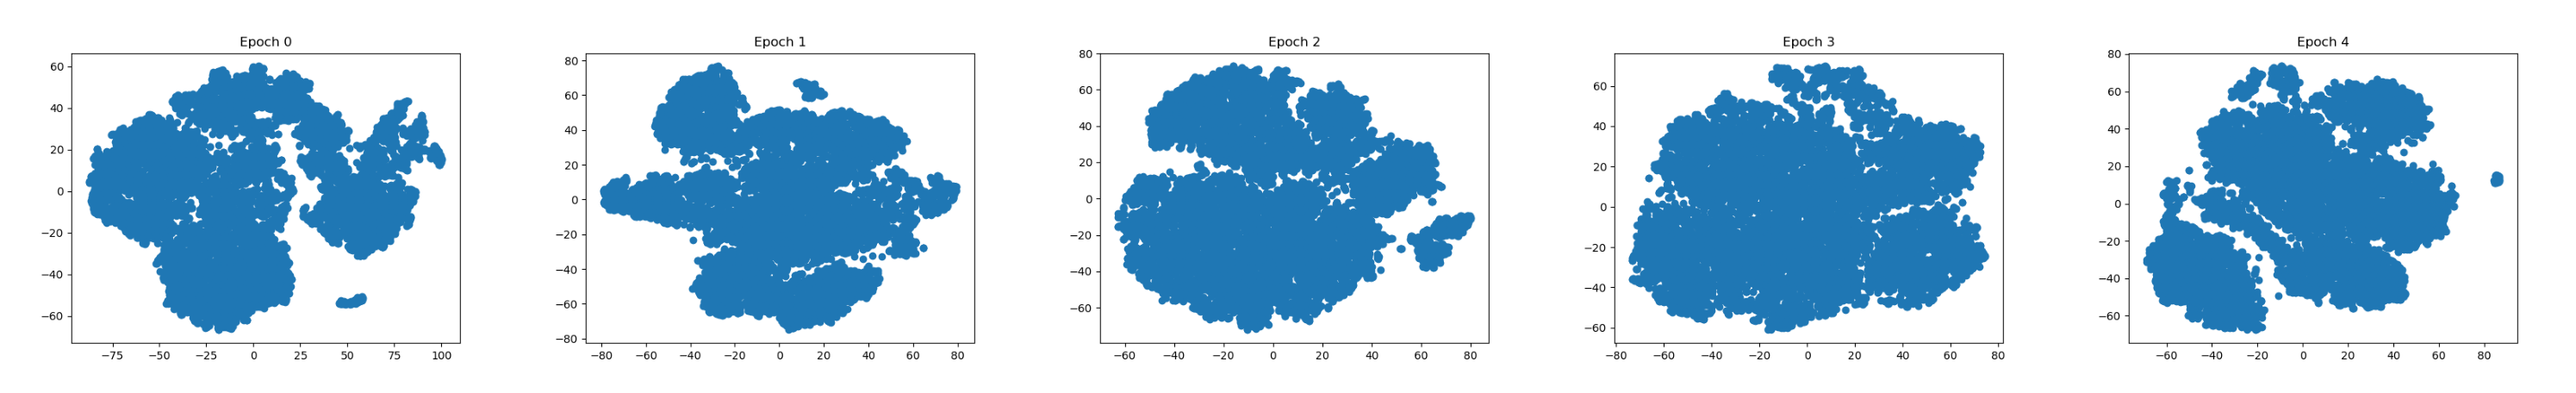

In [73]:
val_type = "train"
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 30))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/latent/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

##### mean pooling

In [87]:
epochs =6
lr = 2e-5
max_length = 250
batch_size = 80
pool ="mean"

trainer(epochs, genes_phast, lr =lr, pool= pool, max_length= max_length, batch_size =batch_size)

Epoch 1 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:34<00:00,  1.31it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.04it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.12it/s]


	ET: 123.22 Seconds
	Train Loss: 0.0461, corrcoef: 0.2605
	Val Loss: 0.0329, corrcoef: 0.4344
	Test Loss: 0.0334, corrcoef: 0.4376
Epoch 2 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:35<00:00,  1.30it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.05it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.10it/s]


	ET: 123.83 Seconds
	Train Loss: 0.0341, corrcoef: 0.4327
	Val Loss: 0.0339, corrcoef: 0.477
	Test Loss: 0.0346, corrcoef: 0.4763
Epoch 3 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:35<00:00,  1.30it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.06it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.14it/s]


	ET: 123.46 Seconds
	Train Loss: 0.0314, corrcoef: 0.512
	Val Loss: 0.0322, corrcoef: 0.4942
	Test Loss: 0.0333, corrcoef: 0.4934
Epoch 4 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:35<00:00,  1.30it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.06it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.14it/s]


	ET: 122.98 Seconds
	Train Loss: 0.0283, corrcoef: 0.5779
	Val Loss: 0.0326, corrcoef: 0.5002
	Test Loss: 0.0339, corrcoef: 0.4985
Epoch 5 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:34<00:00,  1.31it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.05it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.13it/s]


	ET: 123.73 Seconds
	Train Loss: 0.0246, corrcoef: 0.6414
	Val Loss: 0.0306, corrcoef: 0.5006
	Test Loss: 0.0324, corrcoef: 0.4889
Epoch 6 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:35<00:00,  1.30it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.05it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.12it/s]

	ET: 123.74 Seconds
	Train Loss: 0.0207, corrcoef: 0.7035
	Val Loss: 0.0329, corrcoef: 0.4923
	Test Loss: 0.0349, corrcoef: 0.479


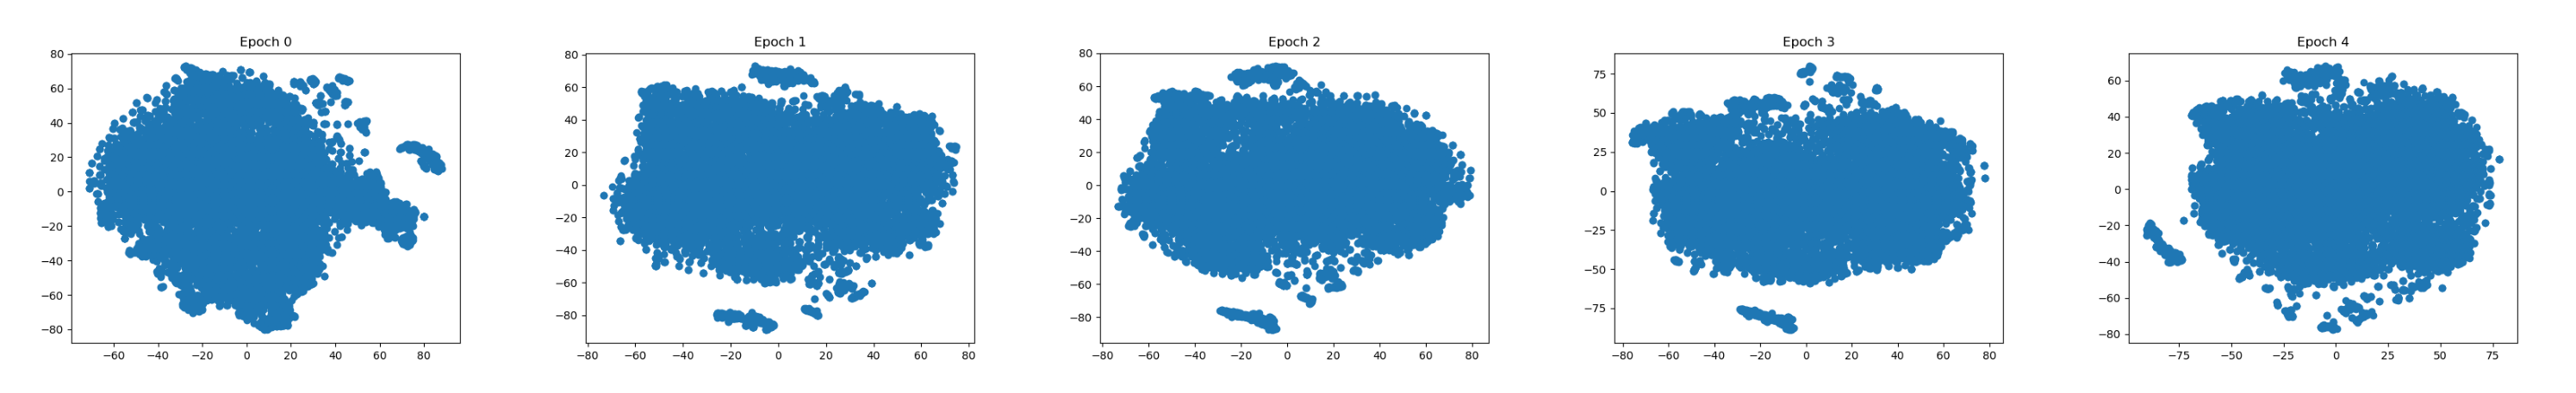

In [89]:
val_type = "train"
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 30))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/latent/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

### Baseline regressor: BERT Base

In [65]:
seed = 42

# PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    
preds = []
labels = []
model = FineTunedBERT(pool= "cls").to("cuda")
model.eval()


for batch_input_ids, batch_attention_mask, batch_labels, _ in tqdm(test_loader):
    with torch.no_grad():

        _, _, pr = model(batch_input_ids.to("cuda") , batch_attention_mask.to("cuda"))
        
#         print(pr.cpu().detach().squeeze())

        preds.extend(pr.cpu().detach().squeeze().tolist())
        labels.extend(batch_labels.cpu().detach().tolist())

corr_base = spearmanr(labels, preds)[0] 
loss_base = nn.MSELoss()(torch.tensor(labels), torch.tensor(preds))


print(f"Mean Squared Error: {loss_base}")
print(f"corr: {corr_base}")

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.19it/s]

Mean Squared Error: 0.09639372676610947
corr: -0.12992214921129486


### Baseline regressor: LR

In [20]:
def getPretrainedEmbeddings(loader, max_length=250, batch_size=1000, pool ="cls"):
    
    
    model = FineTunedBERT(pool= pool).to("cuda")
    
    print("Get embeddings ...")
    
    embeddings=[]
    labels = []
    genes = []
    genes_dict = genes_phast["Gene name"].to_dict()
    model.eval()
    for batch_input_ids, batch_attention_mask, batch_labels, g_name in tqdm(loader):
        with torch.no_grad():
            
            pooled_embeddings, _, _ = model(batch_input_ids.to("cuda") , batch_attention_mask.to("cuda"))
            embeddings.append(pooled_embeddings.cpu().detach())
            labels.append(batch_labels)
            
            for g in g_name:
                genes.append(genes_dict[int(g)])
    
    
    concat_embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(concat_embeddings.size())
    
    return concat_embeddings, labels, genes


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

train_loader, val_loader, test_loader = process_data(genes_phast, 250 , 80)
X_train, y_train, genes_train = getPretrainedEmbeddings(train_loader)
X_test, y_test, genes_test = getPretrainedEmbeddings(test_loader)


regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"corr: {spearmanr(y_test, y_pred)[0]}")


Get embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:30<00:00,  4.06it/s]


torch.Size([9871, 768])
Get embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.22it/s]


torch.Size([2178, 768])
Mean Squared Error: 0.040868376918430115
corr: 0.32399747379971


### Baseline: Gene2Vec

In [27]:
Gene2Vec = dict()

file_path = f'data/gene2vec_embeddings.txt'
with open(file_path, 'r') as file:
    for line in file:
        
        g_name, g_embed = line.strip().split("	")
        g_embed = [float(value) for value in g_embed.split()] 
        
        Gene2Vec[g_name.strip()] = g_embed

genes_dict = genes_phast.set_index("Gene name")["Conservation"].to_dict()

X_train_vec, y_train_vec = [], []
for g in genes_train:
    
    if Gene2Vec.get(g, False):
        X_train_vec.append(Gene2Vec[g])
        y_train_vec.append(genes_dict[g])
        
X_test_vec, y_test_vec = [], []
for g in genes_test:
    
    if Gene2Vec.get(g, False):
        X_test_vec.append(Gene2Vec[g])
        y_test_vec.append(genes_dict[g])


regressor = LinearRegression()
regressor.fit(X_train_vec, y_train_vec)

y_pred_vec = regressor.predict(X_test_vec)

mse_vec = mean_squared_error(y_test_vec, y_pred_vec)
r2_vec = r2_score(y_test_vec, y_pred_vec)

print(f"Mean Squared Error: {mse_vec}")
print(f"corr: {spearmanr(y_test_vec, y_pred_vec)[0]}")

Mean Squared Error: 0.034408538766774355
corr: 0.4051076023825084


# Subcellular Locations

In [14]:
def plot_latent(latents, labels, epoch, validation_type="train"):
    
    tsne = TSNE(n_components=2)
    scaler = StandardScaler()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        latents_tsne = tsne.fit_transform(latents)
    

    for i, class_label in enumerate(np.unique(labels)):
        class_indices = labels == class_label
        cl = {0:'Cytoplasm', 1:'Nucleus', 2:'Cell membrane'}[class_label]
        plt.scatter(latents_tsne[class_indices, 0],
                    latents_tsne[class_indices, 1],
                    label=f'{cl}')

    
#     plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1])
    
    plt.title(f'Epoch {epoch}')
    plt.legend()
    plt.savefig(f"saved-figures/subloc/{validation_type}/latent_{epoch}.png")
    plt.close()


def train(loader, model, optimizer, gene2vec_flag = False, device = "cuda"):
    
 
    train_loss = 0
    latents  = []

    total_preds = []
    total_labels = []

    loss_fn = nn.CrossEntropyLoss()

    
    model.train()
    for batch in tqdm(loader): 

        
        if gene2vec_flag:
            batch_inputs, batch_masks, gene2vec_embeddings, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device), batch[3].to(device)
            embeddings, _ , preds = model(batch_inputs, batch_masks, gene2vec = gene2vec_embeddings)
            
        else:
            batch_inputs, batch_masks , labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device)
            embeddings, _ , preds = model(batch_inputs, batch_masks)

#         print(f"test sizes: {preds}, {labels}")
#         print(f"test sizes: {len(preds)}, {len(labels)}")
        
        loss = loss_fn(preds, labels)
        
        train_loss += loss.item()

        
        #Aggregation
        embeddings = torch.tensor(embeddings.cpu().detach().numpy())
        latents.append(embeddings) 
        total_preds.extend(preds.argmax(1).type(torch.int).to('cpu').numpy())
        total_labels.extend(labels.type(torch.int).to('cpu').numpy())

            
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(loader)
    latents = torch.cat(latents, dim=0)
                
    return model, train_loss, total_labels, total_preds,  latents




def validation (loader, model, gene2vec_flag = False, device = "cuda"):
    
    val_loss = 0
    total_preds = []
    total_labels = []

    loss_fn = nn.CrossEntropyLoss()
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader): 

            if gene2vec_flag:
                batch_inputs, batch_masks, gene2vec_embeddings, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device), batch[3].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks, gene2vec = gene2vec_embeddings)

            else:
                batch_inputs, batch_masks , labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks)


            loss = loss_fn(preds, labels)

            val_loss += loss.item()
            total_preds.extend(preds.argmax(1).type(torch.int).to('cpu').numpy())
            total_labels.extend(labels.type(torch.int).to('cpu').numpy())


    val_loss /= len(loader)

    return model, val_loss, total_labels, total_preds


def test(loader, model, gene2vec_flag = False, device = "cuda"):
    
    test_loss = 0
    total_preds = []
    total_labels = []

    loss_fn = nn.CrossEntropyLoss()

    latents = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader): 

            if gene2vec_flag:
                batch_inputs, batch_masks, gene2vec_embeddings, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device), batch[3].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks, gene2vec = gene2vec_embeddings)

            else:
                batch_inputs, batch_masks, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks)


            loss = loss_fn(preds, labels)        
            test_loss += loss.item()

            embeddings = torch.tensor(embeddings.cpu().detach().numpy())
            latents.append(embeddings)
            total_preds.extend(preds.argmax(1).type(torch.int).to('cpu').numpy())
            total_labels.extend(labels.type(torch.int).to('cpu').numpy())

        
        
    test_loss /= len(loader)
    latents = torch.cat(latents, dim=0)

                
    return model, test_loss, total_labels, total_preds, latents

def process_data_sub(genes, max_length, batch_size,
                 gene2vec_flag = False, model_name= "bert-base-cased"):
    
    
    
    sentences, labels, g_index, g_name = genes["Summary"].tolist() , genes["Y0"].tolist(), genes.index.tolist() , genes["Gene name"].tolist()
    
    if "xlnet" in model_name:
        tokenizer = XLNetTokenizer.from_pretrained(model_name)

    else:    
        tokenizer = BertTokenizerFast.from_pretrained(model_name)
        
        

    tokens = tokenizer.batch_encode_plus(sentences, max_length = max_length, padding="max_length",
                                         truncation=True)

    data = {'input_ids': tokens["input_ids"],
            'token_type_ids': tokens["token_type_ids"],
            'attention_mask': tokens["attention_mask"],
            "labels": labels,
            "g_index": g_index,
            "g_name": g_name
           }
    
    tokens_df = pd.DataFrame(data)
    print(f"Shape of tokens_df before gene2vec:{tokens_df.shape}")
    #############################################
    if gene2vec_flag:
        print("Adding Gene2Vec data ...")
        
        Gene2Vec = dict()

        file_path = f'data/gene2vec_embeddings.txt'
        with open(file_path, 'r') as file:
            for line in file:

                name, embed = line.strip().split("	")
                embed = [float(value) for value in embed.split()] 

                Gene2Vec[name.strip()] = embed
        
        #This will not work
            
            
        tokens_df = tokens_df[tokens_df['g_name'].isin(set(Gene2Vec.keys()) & set(tokens_df["g_name"]))]
        
        tokens_df["gene2vec"] = tokens_df["g_name"].apply(lambda name: 
                                                          Gene2Vec[name])# if name in Gene2Vec.keys() else None )
    
    #############################################
    print(f"Shape of tokens_df after gene2vec:{tokens_df.shape}")
    
    
    
    train_tokens, test_tokens = train_test_split(tokens_df, test_size=0.15,
                                                 random_state=42)
    
    train_tokens, val_tokens = train_test_split(train_tokens,test_size=0.20,
                                                random_state=42)

    train_tokens = train_tokens.reset_index(drop=True)
    val_tokens = val_tokens.reset_index(drop=True)
    test_tokens = test_tokens.reset_index(drop=True)
    
    if gene2vec_flag:
    
        train_dataset = TensorDataset(torch.tensor(train_tokens["input_ids"].tolist()),
                                      torch.tensor(train_tokens["attention_mask"].tolist()),
                                      torch.tensor(train_tokens["gene2vec"]),
                                      torch.tensor(train_tokens["labels"]),
                                      torch.tensor(train_tokens["g_index"]))
        
        val_dataset = TensorDataset(torch.tensor(val_tokens["input_ids"].tolist()) ,
                            torch.tensor(val_tokens["attention_mask"].tolist()),
                            torch.tensor(val_tokens["gene2vec"]),
                            torch.tensor(val_tokens["labels"]),
                            torch.tensor(val_tokens["g_index"]))
        
        test_dataset = TensorDataset(torch.tensor(test_tokens["input_ids"].tolist()),
                             torch.tensor(test_tokens["attention_mask"].tolist()),
                             torch.tensor(test_tokens["gene2vec"]),
                             torch.tensor(test_tokens["labels"]),
                             torch.tensor(test_tokens["g_index"]))
    else:
        train_dataset = TensorDataset(torch.tensor(train_tokens["input_ids"].tolist()),
                                      torch.tensor(train_tokens["attention_mask"].tolist()),
                                      torch.tensor(train_tokens["labels"]),
                                      torch.tensor(train_tokens["g_index"]))
        
        val_dataset = TensorDataset(torch.tensor(val_tokens["input_ids"].tolist()) ,
                            torch.tensor(val_tokens["attention_mask"].tolist()),
                            torch.tensor(val_tokens["labels"]),
                            torch.tensor(val_tokens["g_index"]))
        
        test_dataset = TensorDataset(torch.tensor(test_tokens["input_ids"].tolist()),
                             torch.tensor(test_tokens["attention_mask"].tolist()),
                             torch.tensor(test_tokens["labels"]),
                             torch.tensor(test_tokens["g_index"]))
        
        
        
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    return train_loader, val_loader, test_loader

def trainer_sub(epochs, genes, lr =5e-5, pool="cls",
                max_length= 100, batch_size =100, drop_rate =0.1, gene2vec_flag = False,
                gene2vec_hidden = 200, device = "cuda",
                task="class", model_name= "bert-base-cased"):
    
    
    model = FineTunedBERT(pool= pool, task = task,
                          drop_rate = drop_rate, model_name = model_name,
                          gene2vec_hidden = gene2vec_hidden).to(device)
    
    optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    
    train_loader, val_loader, test_loader = process_data_sub(genes, max_length, batch_size,
                                                             gene2vec_flag = gene2vec_flag,
                                                             model_name = model_name)
    
    for epoch in range(epochs):
        start_time = time.time()
        
        print(f"Epoch {epoch+1} of {epochs}")
        print("-------------------------------")
        
        print("Training ...")
        model, train_loss, labels_train, pred_train, latents = train(train_loader, model, optimizer,
                                                                     gene2vec_flag = gene2vec_flag, device = device)
        
        plot_latent(latents, labels_train,  epoch, validation_type="train")
        
        acc_train = accuracy_score(labels_train, pred_train)
        f1_train = f1_score(labels_train, pred_train, average='weighted')
        prec_train = precision_score(labels_train, pred_train, average='weighted')
        rec_train = recall_score(labels_train, pred_train, average='weighted')

        
        print("Validation ...")
        model, val_loss, labels_val, pred_val  = validation (val_loader, model,
                                                             gene2vec_flag = gene2vec_flag,
                                                             device = device)
        acc_val = accuracy_score(labels_val, pred_val)
        f1_val = f1_score(labels_val, pred_val, average='weighted')
        prec_val = precision_score(labels_val, pred_val, average='weighted')
        rec_val = recall_score(labels_val, pred_val, average='weighted')


        
        print("Testing ...")
        model, test_loss, labels_test, pred_test, _ = test (test_loader, model,
                                                            gene2vec_flag = gene2vec_flag,
                                                           device = device)
        acc_test = accuracy_score(labels_test, pred_test)
        f1_test = f1_score(labels_test, pred_test, average='weighted')
        prec_test = precision_score(labels_test, pred_test, average='weighted')
        rec_test = recall_score(labels_test, pred_test, average='weighted')


        
        print(f'\tET: {round(time.time() - start_time,2)} Seconds')
        print(f'Train Loss: {round(train_loss,4)}, Accuracy: {round(acc_train,4)}, F1: {round(f1_train,4)}, Precision: {round(prec_train,4)}, Recall: {round(rec_train,4)}')
        print(f'Val Loss: {round(val_loss,4)}, Accuracy: {round(acc_val,4)}, F1: {round(f1_val,4)}, Precision: {round(prec_val,4)}, Recall: {round(rec_val,4)}')
        print(f'Test Loss: {round(test_loss,4)}, Accuracy: {round(acc_test,4)}, F1: {round(f1_test,4)}, Precision: {round(prec_test,4)}, Recall: {round(rec_test,4)}')
    return model

In [8]:
#Funmi
knownGenes = []
for i in range (14):
    file_path = f'data/knownGenes/GeneLLM_all_cluster{i}.txt'
    with open(file_path, 'r') as file:
        for line in file:
            knownGenes.append(line.strip()) 

#Macaulay
subcellular_locations = pd.read_csv('data/final_subcellular_location_class.csv')
labels_dict =  subcellular_locations.set_index("0")["Y"].to_dict()



genes = pd.read_csv("data/genes.csv")
genes["Summary"] = genes["Summary"].apply(lambda sent: process_sent(sent))
genes = genes.drop_duplicates(subset='Summary')
genes = genes[genes['Gene name'].isin(knownGenes)]

genes["Y"] = genes["Gene name"].apply(lambda name: labels_dict.get(name,None))
genes_loc = genes.dropna(subset=["Y"]).reset_index(drop=True)
genes_loc["Y0"] = genes_loc["Y"].apply(lambda l:  {'Cytoplasm': 0, 'Nucleus': 1, 'Cell membrane': 2}[l])

genes_loc

Gene name                                            Summary  \
0          FES  This gene encodes the human cellular counterpa...   
1        HSPA2  Enables disordered domain specific binding act...   
2       ZSCAN9  Enables sequence-specific double-stranded DNA ...   
3      SEPTIN3  This gene encodes a member of the sorting nexi...   
4      TBC1D25  This gene encodes an endothelial cell-to-cell ...   
...        ...                                                ...   
8569    RALBP1  RALBP1 plays a role in receptor-mediated endoc...   
8570     OR4D6  This gene encodes a protein that belongs to th...   
8571     TBX20  Olfactory receptors interact with odorant mole...   
8572      DNER  The protein encoded by this gene is a cofactor...   
8573      SOX7  Predicted to enable Notch binding activity. In...   

                                           Interactions              Y  Y0  
0     Homooligomer.Interacts with BCR.Interacts (whe...      Cytoplasm   0  
1                                                   NaN      Cytoplasm   0  
2                                                   NaN        Nucleus   1  
3     Interacts with ATP6V1D; may play a role in cil...      Cytoplasm   0  
4     The sequence BAA95986.2 differs from that show...      Cytoplasm   0  
...                                                 ...            ...  ..  
8569                                                NaN  Cell membrane   2  
8570                              Interacts with PRDM8.  Cell membrane   2  
8571                                                NaN        Nucleus   1  
8572  Forms a 1:1 stoichiometric complex with pancre...  Cell membrane   2  
8573  Interacts with AP1G1.Interacts with NOTCH1 (By...        Nucleus   1  

[8574 rows x 5 columns]

In [8]:
genes_loc["Y"].value_counts()

Y
Cytoplasm        3328
Nucleus          3282
Cell membrane    1964
Name: count, dtype: int64

## Model: $GeneLLM_{tuned}$ 



In [152]:
epochs =6
lr = 1e-5
max_length = 250
batch_size = 80
pool ="cls"
task="class"
gene2vec_flag = False
model_name= "bert-base-cased"


trainer_sub(epochs, genes_loc, lr =lr, pool= pool,
            max_length= max_length, gene2vec_flag = gene2vec_flag,
            batch_size =batch_size, task = task, model_name= model_name )

/home/ajararweh/miniconda3/envs/deepV_a100/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 6
-------------------------------
Training ...


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:56<00:00,  1.30it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.18it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.22it/s]


	ET: 72.98 Seconds
Train Loss: 0.9368, Accuracy: 0.5226, F1: 0.5162
Val Loss: 0.7196, Accuracy: 0.6818, F1: 0.683
Test Loss: 0.7159, Accuracy: 0.6946, F1: 0.6949
Epoch 2 of 6
-------------------------------
Training ...


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:56<00:00,  1.29it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.19it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.23it/s]


	ET: 73.36 Seconds
Train Loss: 0.6517, Accuracy: 0.7375, F1: 0.7388
Val Loss: 0.6069, Accuracy: 0.7497, F1: 0.751
Test Loss: 0.6204, Accuracy: 0.7389, F1: 0.7398
Epoch 3 of 6
-------------------------------
Training ...


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:56<00:00,  1.30it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.20it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.24it/s]


	ET: 73.19 Seconds
Train Loss: 0.5821, Accuracy: 0.772, F1: 0.7729
Val Loss: 0.5905, Accuracy: 0.7661, F1: 0.7671
Test Loss: 0.6092, Accuracy: 0.7514, F1: 0.7514
Epoch 4 of 6
-------------------------------
Training ...


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:56<00:00,  1.30it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.22it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.26it/s]


	ET: 72.97 Seconds
Train Loss: 0.5382, Accuracy: 0.7976, F1: 0.7982
Val Loss: 0.581, Accuracy: 0.7778, F1: 0.7787
Test Loss: 0.6032, Accuracy: 0.7599, F1: 0.7602
Epoch 5 of 6
-------------------------------
Training ...


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:56<00:00,  1.30it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.23it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.26it/s]


	ET: 72.85 Seconds
Train Loss: 0.4991, Accuracy: 0.8144, F1: 0.8147
Val Loss: 0.5593, Accuracy: 0.7997, F1: 0.8002
Test Loss: 0.5865, Accuracy: 0.7731, F1: 0.7736
Epoch 6 of 6
-------------------------------
Training ...


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:56<00:00,  1.30it/s]


Validation ...


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.23it/s]


Testing ...


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.27it/s]

	ET: 72.36 Seconds
Train Loss: 0.4476, Accuracy: 0.8415, F1: 0.8416
Val Loss: 0.5592, Accuracy: 0.7984, F1: 0.7993
Test Loss: 0.5889, Accuracy: 0.7817, F1: 0.7823


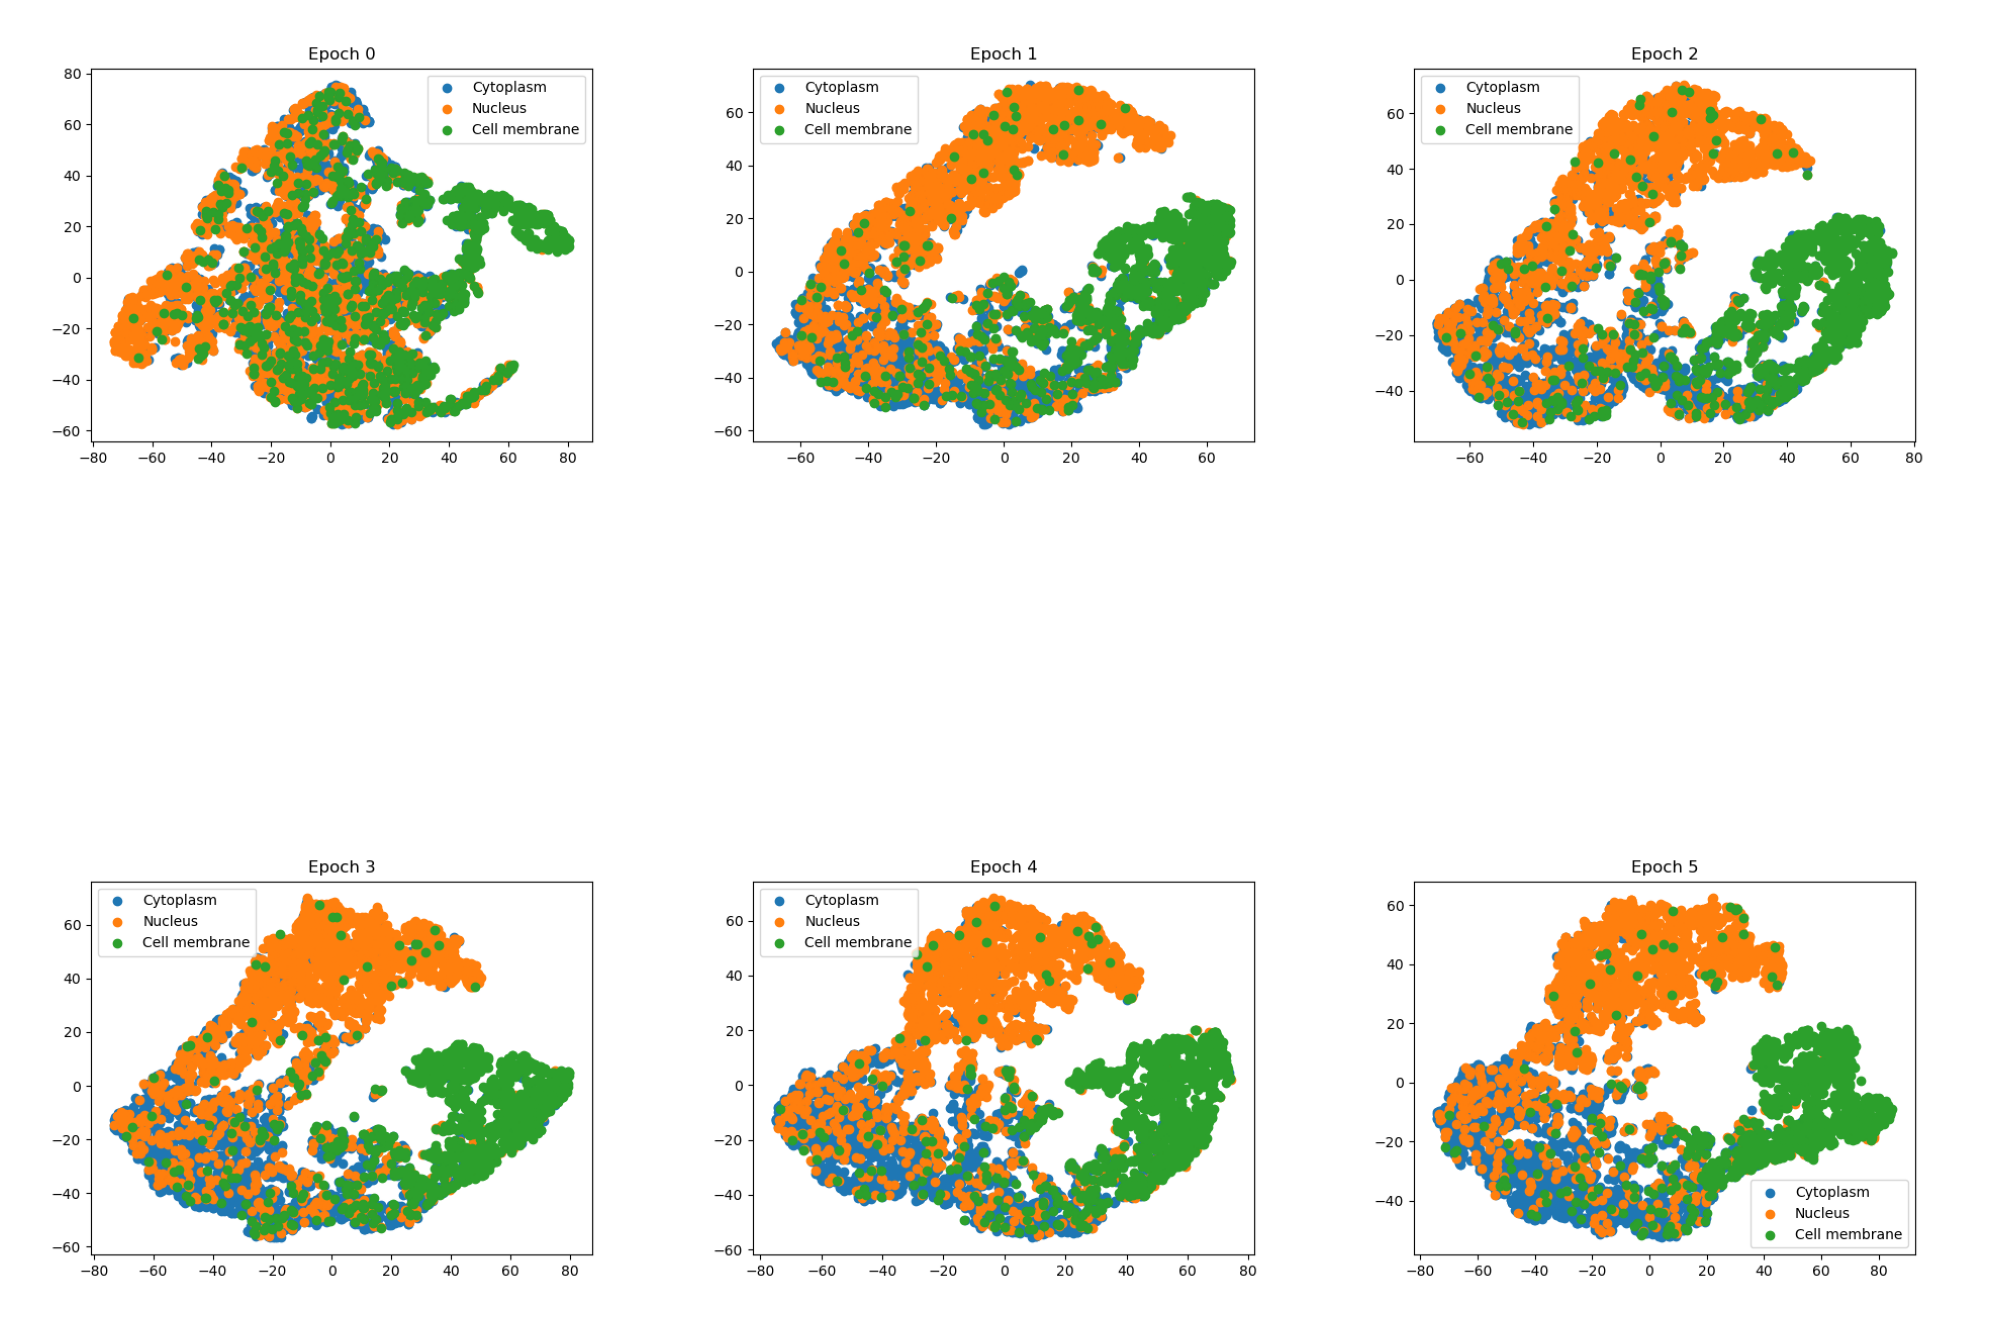

In [156]:
val_type = "train"
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/subloc/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

## Baseline classifier: GeneLLM_Base LR

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

train_loader, val_loader, test_loader = process_data(genes_loc, 250 , 80)
X_train, y_train, genes_train = getPretrainedEmbeddings(train_loader)
X_test, y_test, genes_test = getPretrainedEmbeddings(test_loader)


scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {acc}")
print(f"F1: {f1}")


Get embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:17<00:00,  4.13it/s]


torch.Size([5829, 768])
Get embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.33it/s]


torch.Size([1287, 768])
Accuracy: 0.6581196581196581
F1: 0.6574849688864475


/home/ajararweh/miniconda3/envs/deepV_a100/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Baseline: $Gene2Vec_{base}$ with LR

In [108]:
Gene2Vec = dict()

file_path = f'data/gene2vec_embeddings.txt'
with open(file_path, 'r') as file:
    for line in file:
        
        g_name, g_embed = line.strip().split("	")
        g_embed = [float(value) for value in g_embed.split()] 
        
        Gene2Vec[g_name.strip()] = g_embed

genes_dict = genes_loc.set_index("Gene name")["Y0"].to_dict()

X_train_loc, y_train_loc = [], []
for g in genes_train:
    
    if Gene2Vec.get(g, False) and genes_dict.get(g, False):
        X_train_loc.append(Gene2Vec[g])
        y_train_loc.append(genes_dict[g])
        
X_test_loc, y_test_loc = [], []
for g in genes_test:
    
    if Gene2Vec.get(g, False) and genes_dict.get(g, False):
        X_test_loc.append(Gene2Vec[g])
        y_test_loc.append(genes_dict[g])

print(len(X_test_loc))

scaler = StandardScaler().fit(X_train_loc)

X_train_loc = scaler.transform(X_train_loc)
X_test_loc = scaler.transform(X_test_loc)

classifier = LogisticRegression()
classifier.fit(X_train_loc, y_train_loc)

y_pred_loc = classifier.predict(X_test_loc)

acc = accuracy_score(y_test_loc, y_pred_loc)
f1 = f1_score(y_test_loc, y_pred_loc, average='weighted')


print(f"Accuracy: {acc}")
print(f"F1: {f1}")



NameError: name 'genes_train' is not defined

## Baseline: GeneLLM + Gene2Vec [tuned]

In [98]:
epochs =6
lr = 1e-5
max_length = 250
batch_size = 80
pool ="cls"
task="sub_gene2vec"
gene2vec_flag = True
drop_rate = 0.1
gene2vec_hidden = 200
model_name= "bert-base-cased"


trainer_sub(epochs, genes_loc, lr =lr, pool= pool,
            max_length= max_length, drop_rate =drop_rate,
            batch_size = batch_size,gene2vec_flag = gene2vec_flag,
            gene2vec_hidden = gene2vec_hidden, task = task, model_name = model_name)

Shape of tokens_df before gene2vec:(8574, 6)
Adding Gene2Vec data ...
Shape of tokens_df after gene2vec:(7660, 7)
Epoch 1 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:49<00:00,  1.34it/s]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.24it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.22it/s]


	ET: 63.41 Seconds
Train Loss: 0.9246, Accuracy: 0.5611, F1: 0.5534
Val Loss: 0.756, Accuracy: 0.6992, F1: 0.6929
Test Loss: 0.7601, Accuracy: 0.6693, F1: 0.6622
Epoch 2 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:50<00:00,  1.32it/s]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.19it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.17it/s]


	ET: 63.66 Seconds
Train Loss: 0.6688, Accuracy: 0.7293, F1: 0.7291
Val Loss: 0.6574, Accuracy: 0.736, F1: 0.7334
Test Loss: 0.6674, Accuracy: 0.7215, F1: 0.7205
Epoch 3 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:50<00:00,  1.31it/s]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.20it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.19it/s]


	ET: 64.07 Seconds
Train Loss: 0.5902, Accuracy: 0.7675, F1: 0.7679
Val Loss: 0.6334, Accuracy: 0.7506, F1: 0.7498
Test Loss: 0.6464, Accuracy: 0.7424, F1: 0.7434
Epoch 4 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:50<00:00,  1.31it/s]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.21it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.18it/s]


	ET: 63.85 Seconds
Train Loss: 0.5368, Accuracy: 0.8011, F1: 0.8015
Val Loss: 0.6393, Accuracy: 0.7513, F1: 0.7515
Test Loss: 0.6569, Accuracy: 0.7459, F1: 0.7477
Epoch 5 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:50<00:00,  1.31it/s]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.21it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.19it/s]


	ET: 63.98 Seconds
Train Loss: 0.4862, Accuracy: 0.8201, F1: 0.8203
Val Loss: 0.6079, Accuracy: 0.7721, F1: 0.7723
Test Loss: 0.6066, Accuracy: 0.765, F1: 0.766
Epoch 6 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:50<00:00,  1.32it/s]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.21it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.20it/s]

	ET: 64.33 Seconds
Train Loss: 0.4337, Accuracy: 0.845, F1: 0.8452
Val Loss: 0.6453, Accuracy: 0.7629, F1: 0.7622
Test Loss: 0.6438, Accuracy: 0.7641, F1: 0.7653


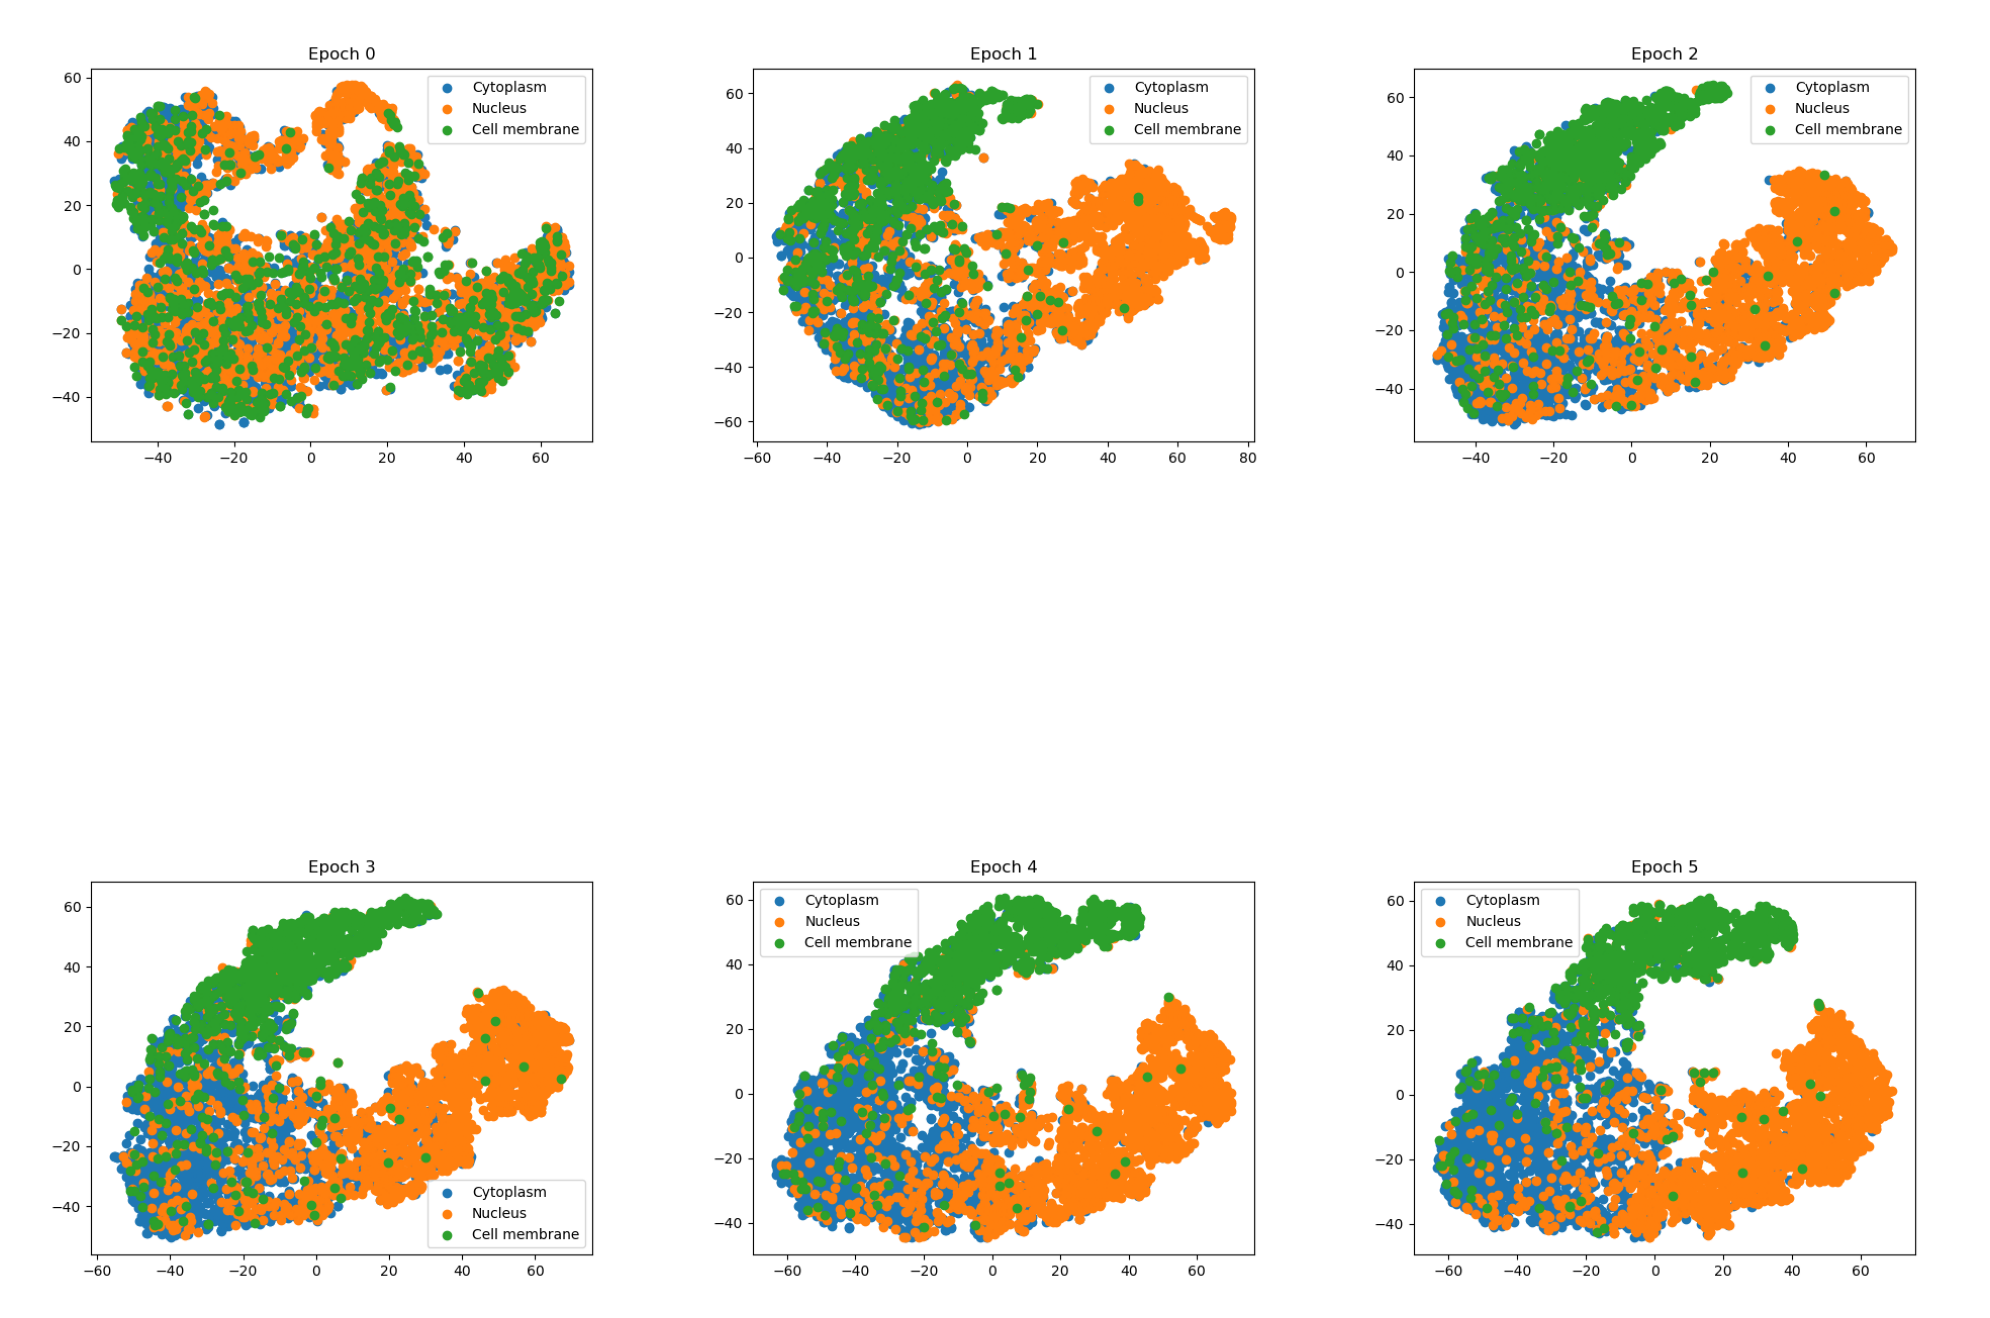

In [81]:
val_type = "train"
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/subloc/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

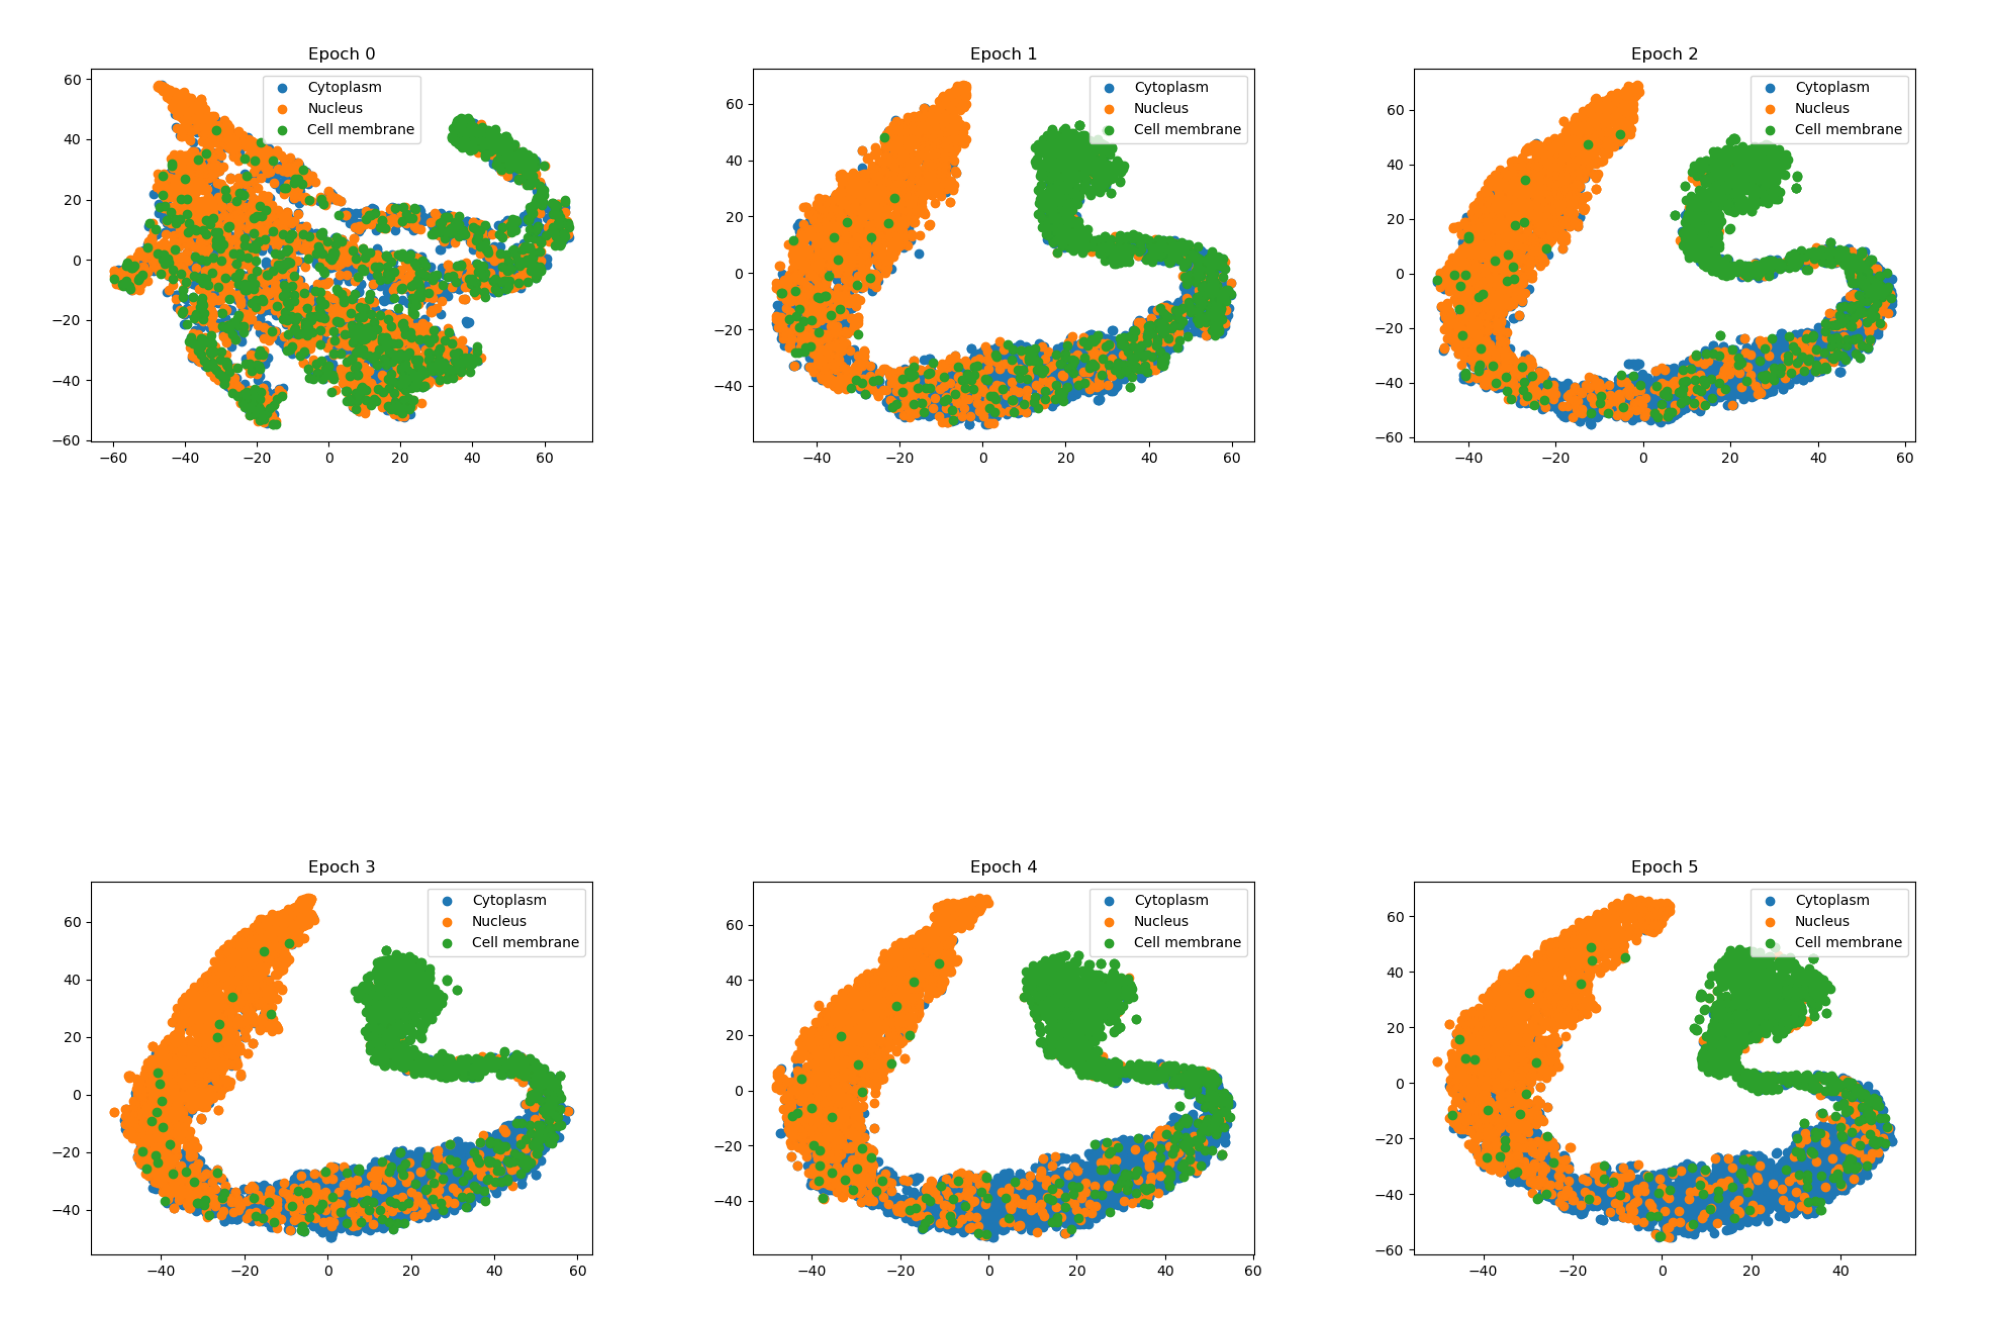

In [79]:
val_type = "train"
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/subloc/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

## Baseline: $GeneLLM_{BioBERT_{tuned}}$ 

In [29]:
epochs =6
lr = 1e-5
max_length = 512
batch_size = 60
pool ="mean"
task="class"
gene2vec_flag = False
drop_rate = 0.1
gene2vec_hidden = 200
device = "cuda"
model_name= "dmis-lab/biobert-base-cased-v1.1"



trainer_sub(epochs, genes_loc, lr =lr, pool= pool,
            max_length= max_length, drop_rate =drop_rate,
            batch_size = batch_size, gene2vec_flag = gene2vec_flag,
            gene2vec_hidden = gene2vec_hidden,
            task = task, model_name= model_name, device = device)

/home/ajararweh/miniconda3/envs/deepV_a100/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Shape of tokens_df before gene2vec:(8574, 6)
Shape of tokens_df after gene2vec:(8574, 6)
Epoch 1 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [02:04<00:00,  1.27s/it]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.37it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.36it/s]


	ET: 151.29 Seconds
Train Loss: 0.7567, Accuracy: 0.6567, F1: 0.6545
Val Loss: 0.5597, Accuracy: 0.7764, F1: 0.7788
Test Loss: 0.5974, Accuracy: 0.77, F1: 0.7717
Epoch 2 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [02:05<00:00,  1.28s/it]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.38it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.37it/s]


	ET: 152.32 Seconds
Train Loss: 0.5295, Accuracy: 0.7934, F1: 0.7942
Val Loss: 0.5048, Accuracy: 0.808, F1: 0.8092
Test Loss: 0.5468, Accuracy: 0.7941, F1: 0.7953
Epoch 3 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [02:05<00:00,  1.28s/it]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.38it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.37it/s]


	ET: 152.19 Seconds
Train Loss: 0.479, Accuracy: 0.8197, F1: 0.8202
Val Loss: 0.5005, Accuracy: 0.8169, F1: 0.8175
Test Loss: 0.5382, Accuracy: 0.798, F1: 0.7987
Epoch 4 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [02:05<00:00,  1.28s/it]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.38it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.37it/s]


	ET: 152.24 Seconds
Train Loss: 0.4315, Accuracy: 0.8447, F1: 0.8451
Val Loss: 0.5098, Accuracy: 0.8182, F1: 0.8193
Test Loss: 0.5516, Accuracy: 0.8026, F1: 0.8033
Epoch 5 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [02:04<00:00,  1.27s/it]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.39it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.38it/s]


	ET: 151.57 Seconds
Train Loss: 0.3832, Accuracy: 0.8652, F1: 0.8654
Val Loss: 0.5332, Accuracy: 0.8121, F1: 0.8131
Test Loss: 0.571, Accuracy: 0.7972, F1: 0.798
Epoch 6 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [02:04<00:00,  1.27s/it]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.39it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.38it/s]

	ET: 151.73 Seconds
Train Loss: 0.3299, Accuracy: 0.8902, F1: 0.8903
Val Loss: 0.5822, Accuracy: 0.7956, F1: 0.7967
Test Loss: 0.6315, Accuracy: 0.7887, F1: 0.7897


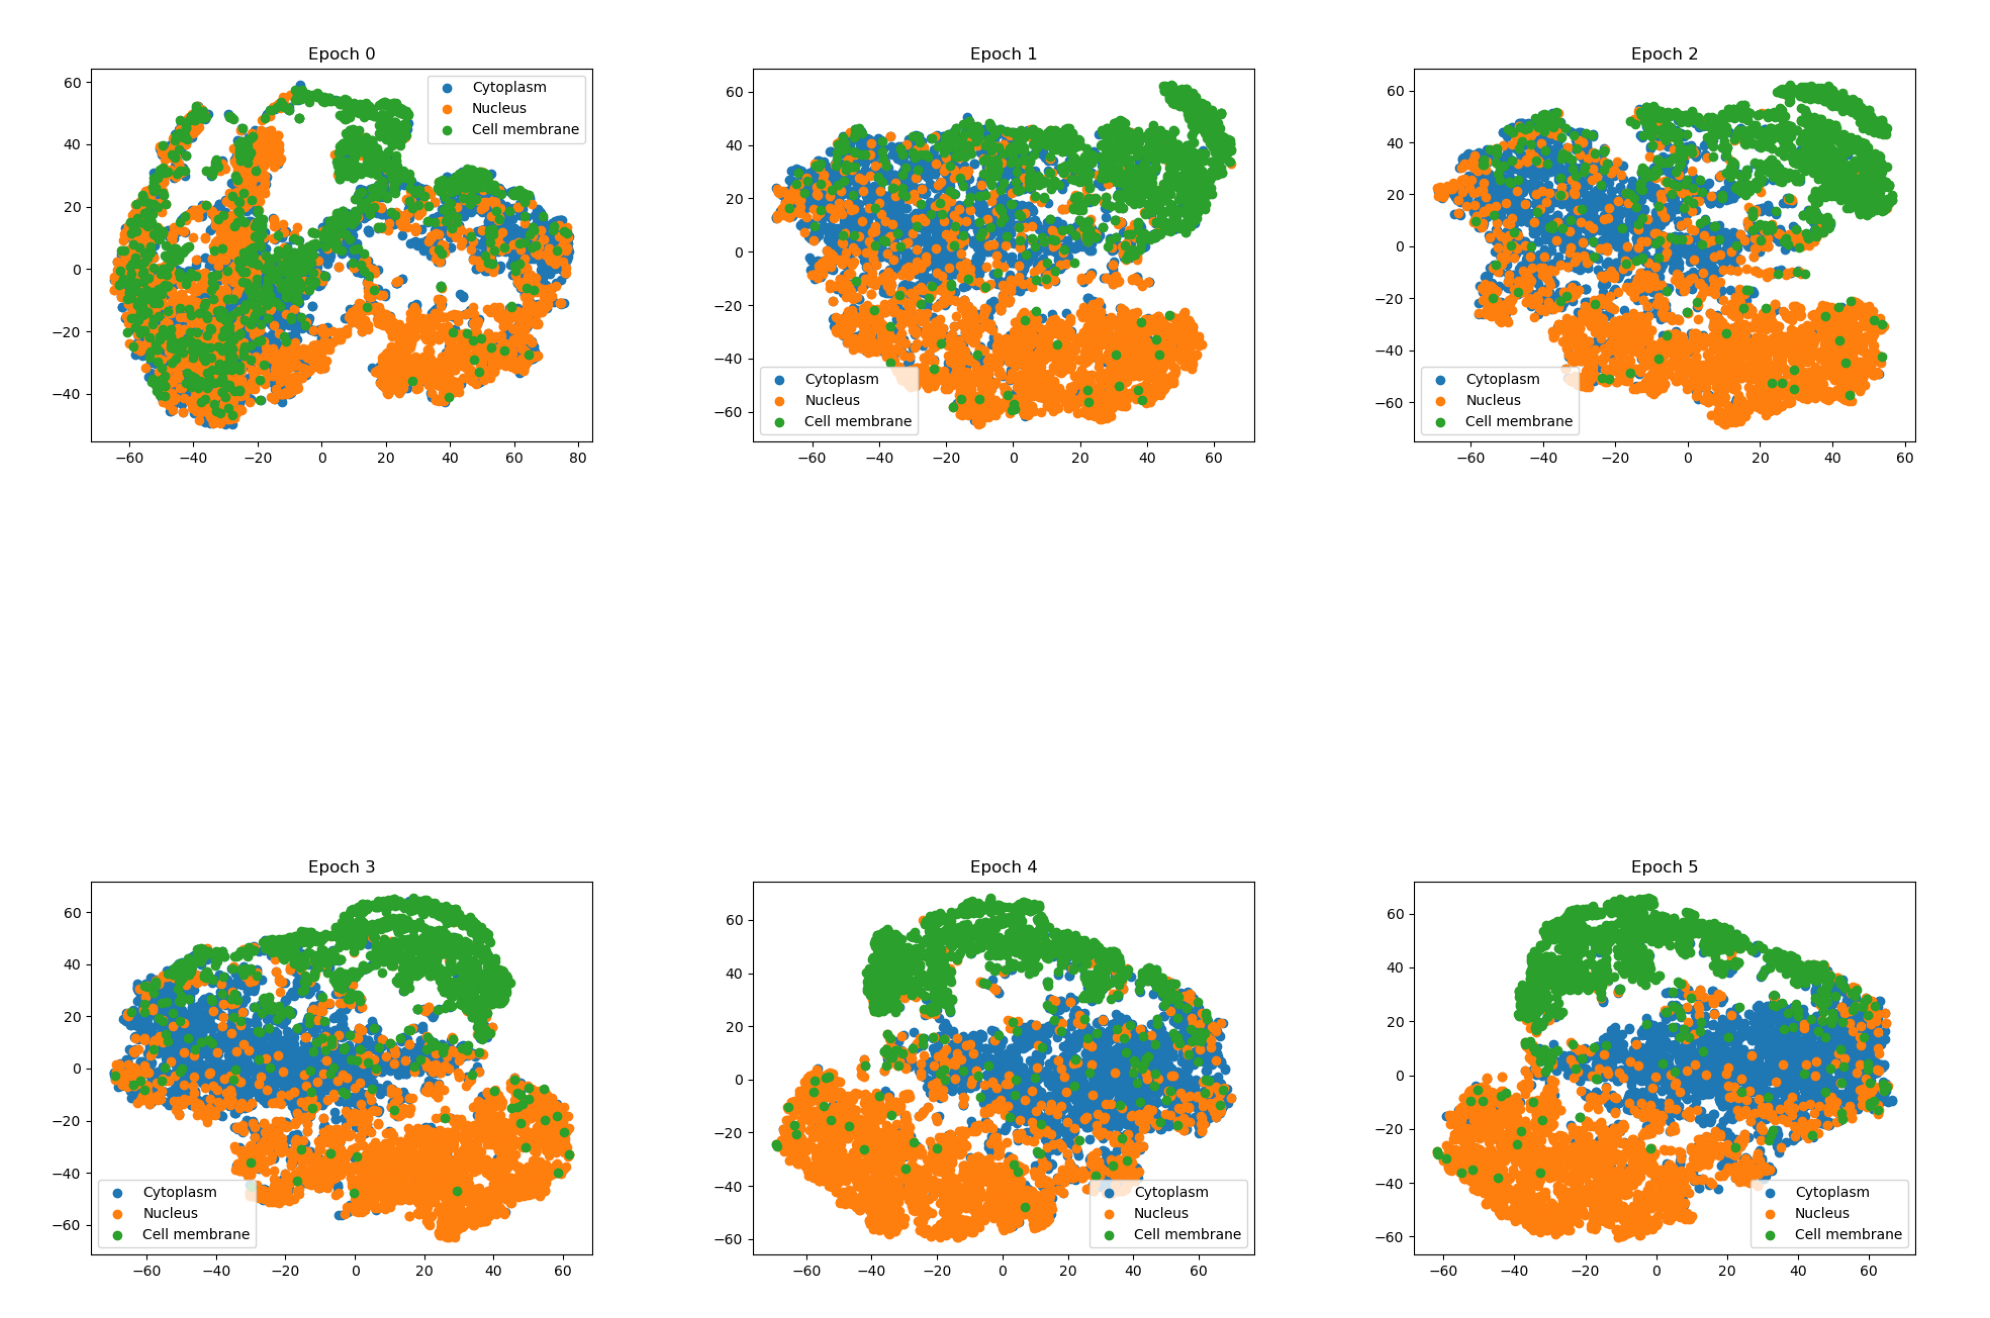

In [28]:
val_type = "train"
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/subloc/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

## Baseline: $GeneLLM_{PubMedBERT_{tuned}}$ [BASE]

@misc{pubmedbert,
  author = {Yu Gu and Robert Tinn and Hao Cheng and Michael Lucas and Naoto Usuyama and Xiaodong Liu and Tristan Naumann and Jianfeng Gao and Hoifung Poon},
  title = {Domain-Specific Language Model Pretraining for Biomedical Natural Language Processing},
  year = {2020},
  eprint = {arXiv:2007.15779},
}


In [33]:
epochs =6
lr = 1e-5
max_length = 512
batch_size = 60
pool ="mean"
task="class"
gene2vec_flag = False
drop_rate = 0.1
gene2vec_hidden = 200
device = "cuda"

#microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract
model_name= "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"




trainer_sub(epochs, genes_loc, lr =lr, pool= pool,
            max_length= max_length, drop_rate =drop_rate,
            batch_size = batch_size, gene2vec_flag = gene2vec_flag,
            gene2vec_hidden = gene2vec_hidden,
            task = task, model_name= model_name, device = device)

/home/ajararweh/miniconda3/envs/deepV_a100/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Shape of tokens_df before gene2vec:(8574, 6)
Shape of tokens_df after gene2vec:(8574, 6)
Epoch 1 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [02:03<00:00,  1.26s/it]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.38it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.37it/s]


	ET: 150.21 Seconds
Train Loss: 0.7225, Accuracy: 0.6638, F1: 0.6632
Val Loss: 0.5313, Accuracy: 0.7929, F1: 0.7951
Test Loss: 0.5603, Accuracy: 0.7925, F1: 0.7942
Epoch 2 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [02:04<00:00,  1.27s/it]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.39it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.37it/s]


	ET: 151.41 Seconds
Train Loss: 0.5058, Accuracy: 0.8082, F1: 0.8088
Val Loss: 0.4965, Accuracy: 0.8182, F1: 0.8195
Test Loss: 0.5325, Accuracy: 0.8073, F1: 0.8085
Epoch 3 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [02:04<00:00,  1.27s/it]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.39it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.38it/s]


	ET: 151.09 Seconds
Train Loss: 0.4508, Accuracy: 0.8334, F1: 0.8339
Val Loss: 0.5007, Accuracy: 0.8203, F1: 0.8211
Test Loss: 0.5307, Accuracy: 0.8135, F1: 0.8144
Epoch 4 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [02:04<00:00,  1.27s/it]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.38it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.37it/s]


	ET: 151.29 Seconds
Train Loss: 0.4022, Accuracy: 0.8554, F1: 0.8556
Val Loss: 0.5266, Accuracy: 0.8196, F1: 0.8206
Test Loss: 0.5658, Accuracy: 0.8065, F1: 0.8074
Epoch 5 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [02:04<00:00,  1.27s/it]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.39it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.37it/s]


	ET: 152.24 Seconds
Train Loss: 0.3549, Accuracy: 0.8765, F1: 0.8766
Val Loss: 0.5679, Accuracy: 0.8114, F1: 0.8128
Test Loss: 0.6194, Accuracy: 0.8003, F1: 0.8015
Epoch 6 of 6
-------------------------------
Training ...


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [02:04<00:00,  1.27s/it]


Validation ...


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.39it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.37it/s]

	ET: 151.67 Seconds
Train Loss: 0.2917, Accuracy: 0.9029, F1: 0.903
Val Loss: 0.6202, Accuracy: 0.8018, F1: 0.8027
Test Loss: 0.6492, Accuracy: 0.8011, F1: 0.8018


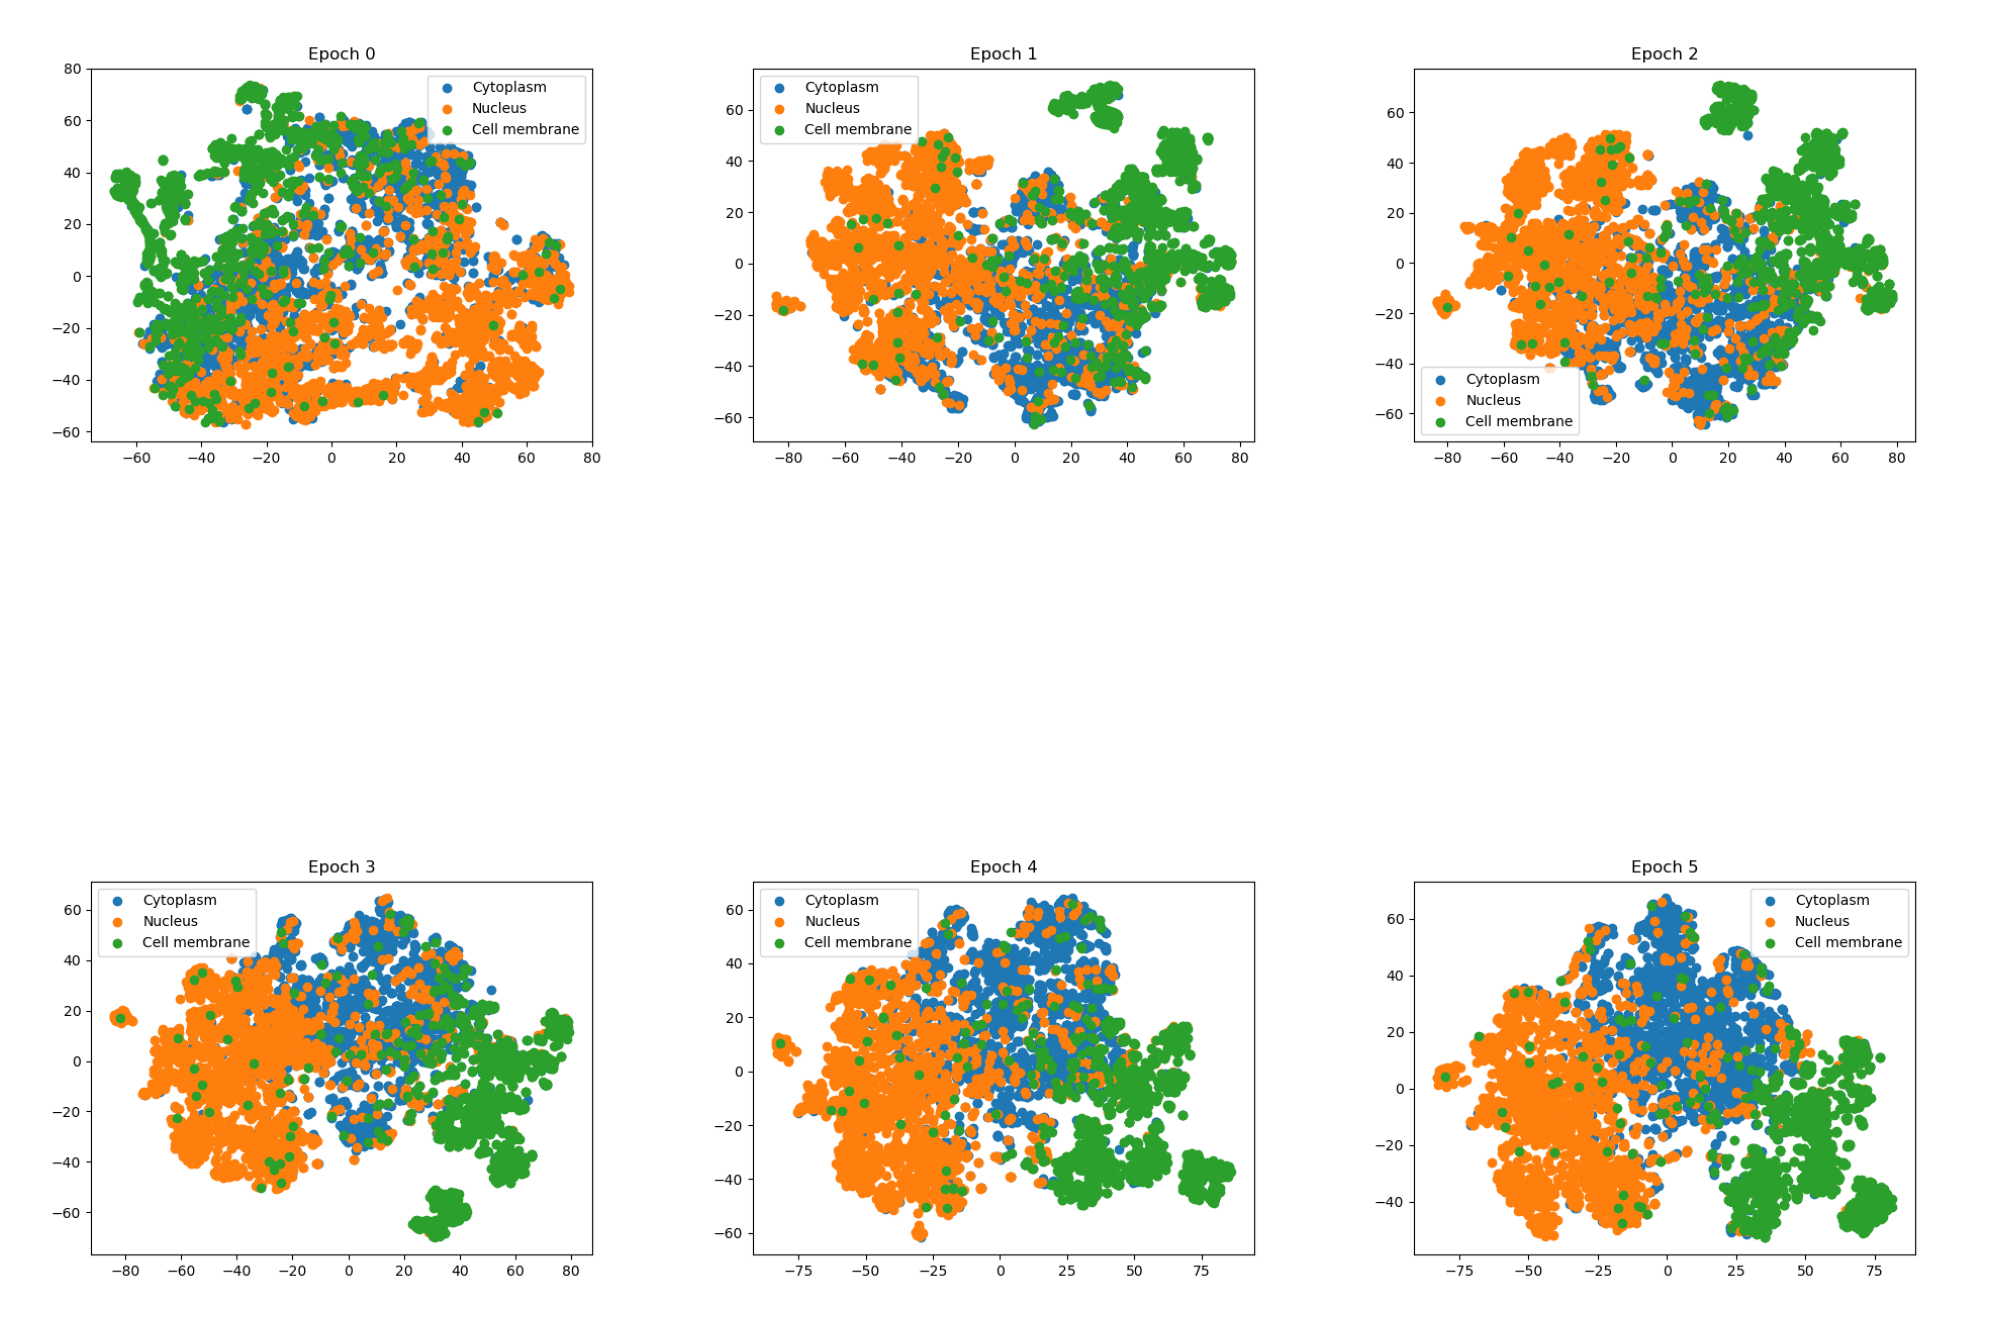

In [34]:
val_type = "train"
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/subloc/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

## Baseline: $GeneLLM_{PubMedBERT_{tuned}}$ [LARGE]

In [37]:
epochs =6
lr = 1e-5
max_length = 512
batch_size = 10
pool ="mean"
task="class"
gene2vec_flag = False
drop_rate = 0.1
gene2vec_hidden = 200
device = "cuda"

model_name= "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract"




trainer_sub(epochs, genes_loc, lr =lr, pool= pool,
            max_length= max_length, drop_rate =drop_rate,
            batch_size = batch_size, gene2vec_flag = gene2vec_flag,
            gene2vec_hidden = gene2vec_hidden,
            task = task, model_name= model_name, device = device)

Shape of tokens_df before gene2vec:(8574, 6)
Shape of tokens_df after gene2vec:(8574, 6)
Epoch 1 of 6
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████| 583/583 [07:07<00:00,  1.36it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████| 146/146 [00:34<00:00,  4.18it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:30<00:00,  4.17it/s]


	ET: 500.92 Seconds
Train Loss: 0.5673, Accuracy: 0.7811, F1: 0.7818
Val Loss: 0.5385, Accuracy: 0.8011, F1: 0.8029
Test Loss: 0.5654, Accuracy: 0.7964, F1: 0.7981
Epoch 2 of 6
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████| 583/583 [07:08<00:00,  1.36it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████| 146/146 [00:34<00:00,  4.19it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:30<00:00,  4.18it/s]


	ET: 501.42 Seconds
Train Loss: 0.4346, Accuracy: 0.8458, F1: 0.8461
Val Loss: 0.5544, Accuracy: 0.8032, F1: 0.805
Test Loss: 0.5744, Accuracy: 0.8019, F1: 0.803
Epoch 3 of 6
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████| 583/583 [07:08<00:00,  1.36it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████| 146/146 [00:34<00:00,  4.19it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:30<00:00,  4.19it/s]


	ET: 501.4 Seconds
Train Loss: 0.3222, Accuracy: 0.8837, F1: 0.8838
Val Loss: 0.7014, Accuracy: 0.7894, F1: 0.7917
Test Loss: 0.734, Accuracy: 0.77, F1: 0.7715
Epoch 4 of 6
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████| 583/583 [07:07<00:00,  1.36it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████| 146/146 [00:34<00:00,  4.19it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:30<00:00,  4.18it/s]


	ET: 500.88 Seconds
Train Loss: 0.2193, Accuracy: 0.9221, F1: 0.9221
Val Loss: 0.8927, Accuracy: 0.7798, F1: 0.7813
Test Loss: 0.8798, Accuracy: 0.7739, F1: 0.7744
Epoch 5 of 6
-------------------------------
Training ...


  1%|▉                                                                                | 7/583 [00:05<08:01,  1.20it/s]


KeyboardInterrupt: 

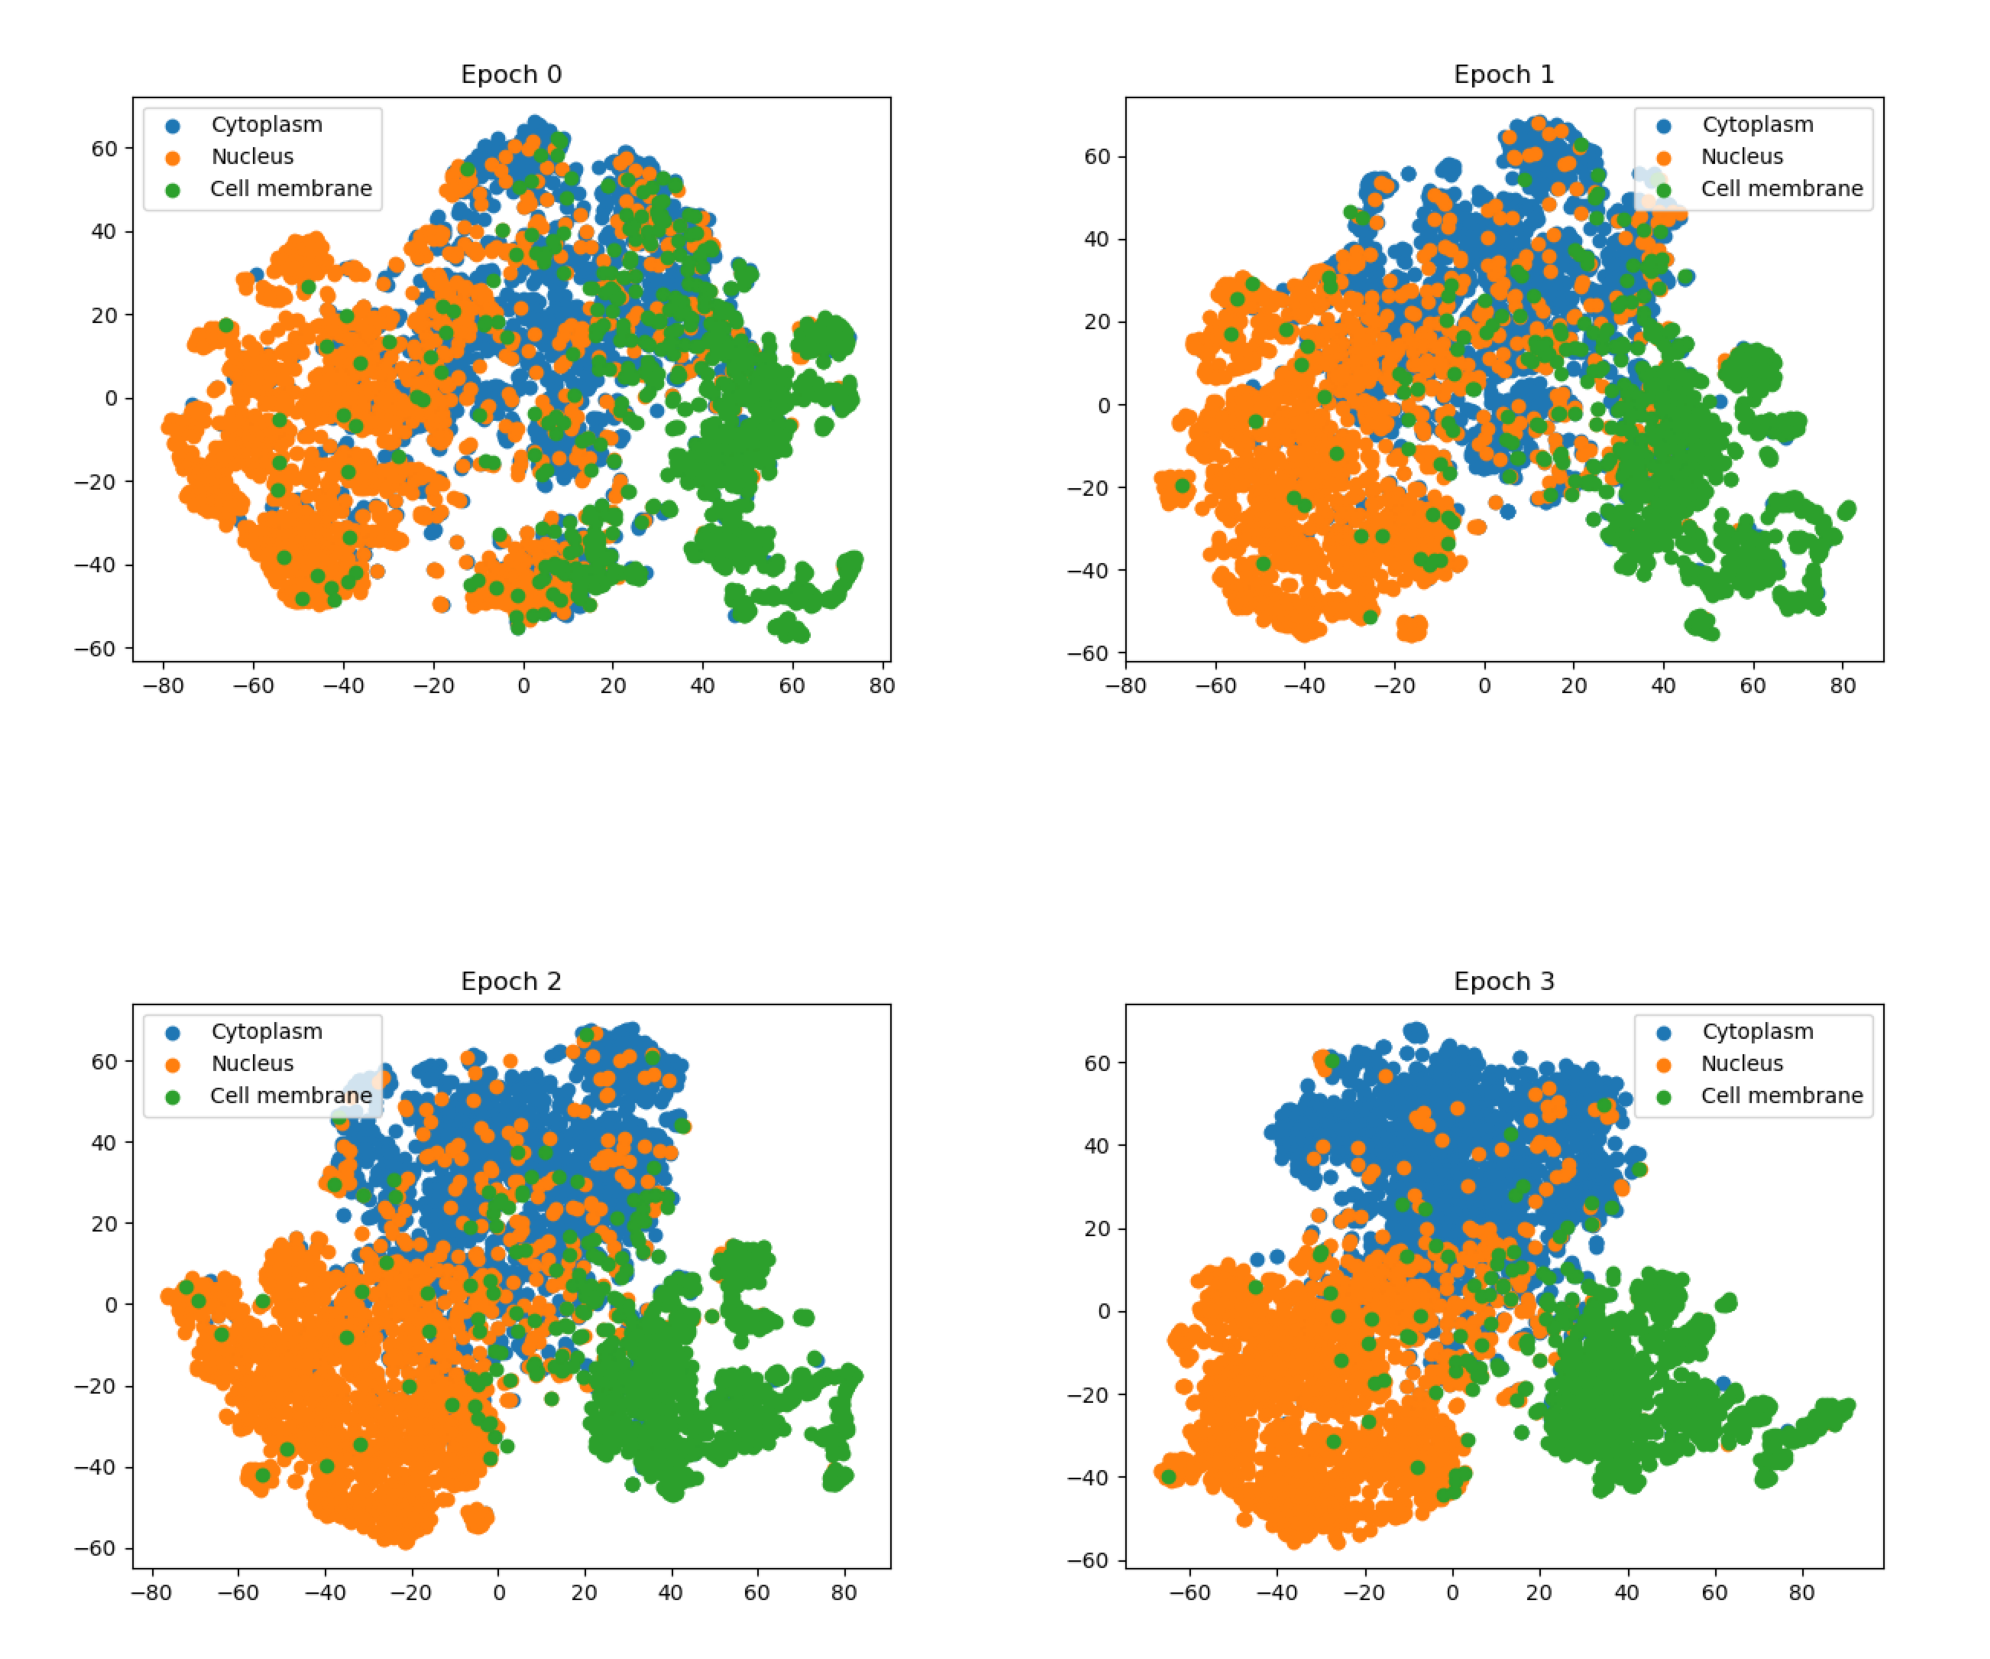

In [39]:
val_type = "train"
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/subloc/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

## Baseline: $GeneLLM_{XLNet_{tuned}}$ [BASE]

In [89]:

epochs =6
lr = 1e-5
max_length = 512
batch_size = 10
pool ="mean"
task="class"
gene2vec_flag = False
drop_rate = 0.1
gene2vec_hidden = 200
device = "cuda"

model_name= "xlnet-base-cased"



trainer_sub(epochs, genes_loc, lr =lr, pool= pool,
            max_length= max_length, drop_rate =drop_rate,
            batch_size = batch_size, gene2vec_flag = gene2vec_flag,
            gene2vec_hidden = gene2vec_hidden,
            task = task, model_name= model_name, device = device)


Shape of tokens_df before gene2vec:(8574, 6)
Shape of tokens_df after gene2vec:(8574, 6)
Epoch 1 of 6
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████| 583/583 [03:31<00:00,  2.75it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████| 146/146 [00:19<00:00,  7.60it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:16<00:00,  7.62it/s]


	ET: 255.67 Seconds
Train Loss: 0.6718, Accuracy: 0.7109, F1: 0.7119
Val Loss: 0.5417, Accuracy: 0.7977, F1: 0.7996
Test Loss: 0.5773, Accuracy: 0.7824, F1: 0.7841
Epoch 2 of 6
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████| 583/583 [03:32<00:00,  2.74it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████| 146/146 [00:19<00:00,  7.67it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:16<00:00,  7.68it/s]


	ET: 255.48 Seconds
Train Loss: 0.5234, Accuracy: 0.7995, F1: 0.8002
Val Loss: 0.5463, Accuracy: 0.7997, F1: 0.8014
Test Loss: 0.5927, Accuracy: 0.7879, F1: 0.7894
Epoch 3 of 6
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████| 583/583 [03:32<00:00,  2.74it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████| 146/146 [00:18<00:00,  7.69it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:16<00:00,  7.69it/s]


	ET: 255.79 Seconds
Train Loss: 0.4647, Accuracy: 0.8255, F1: 0.826
Val Loss: 0.5669, Accuracy: 0.7908, F1: 0.7921
Test Loss: 0.6124, Accuracy: 0.7879, F1: 0.7891
Epoch 4 of 6
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████| 583/583 [03:32<00:00,  2.74it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████| 146/146 [00:19<00:00,  7.65it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:16<00:00,  7.65it/s]


	ET: 255.94 Seconds
Train Loss: 0.3964, Accuracy: 0.8545, F1: 0.8547
Val Loss: 0.6409, Accuracy: 0.7936, F1: 0.7952
Test Loss: 0.6922, Accuracy: 0.784, F1: 0.7853
Epoch 5 of 6
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████| 583/583 [03:32<00:00,  2.75it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████| 146/146 [00:18<00:00,  7.69it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:16<00:00,  7.67it/s]


	ET: 255.43 Seconds
Train Loss: 0.3152, Accuracy: 0.8837, F1: 0.8837
Val Loss: 0.7622, Accuracy: 0.7901, F1: 0.7915
Test Loss: 0.8323, Accuracy: 0.7747, F1: 0.7756
Epoch 6 of 6
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████| 583/583 [03:31<00:00,  2.75it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████| 146/146 [00:19<00:00,  7.67it/s]


Testing ...


100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:16<00:00,  7.59it/s]

	ET: 255.45 Seconds
Train Loss: 0.251, Accuracy: 0.9082, F1: 0.9082
Val Loss: 0.8534, Accuracy: 0.773, F1: 0.7748
Test Loss: 0.8918, Accuracy: 0.7607, F1: 0.7616


FineTunedBERT(
  (bert): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm)

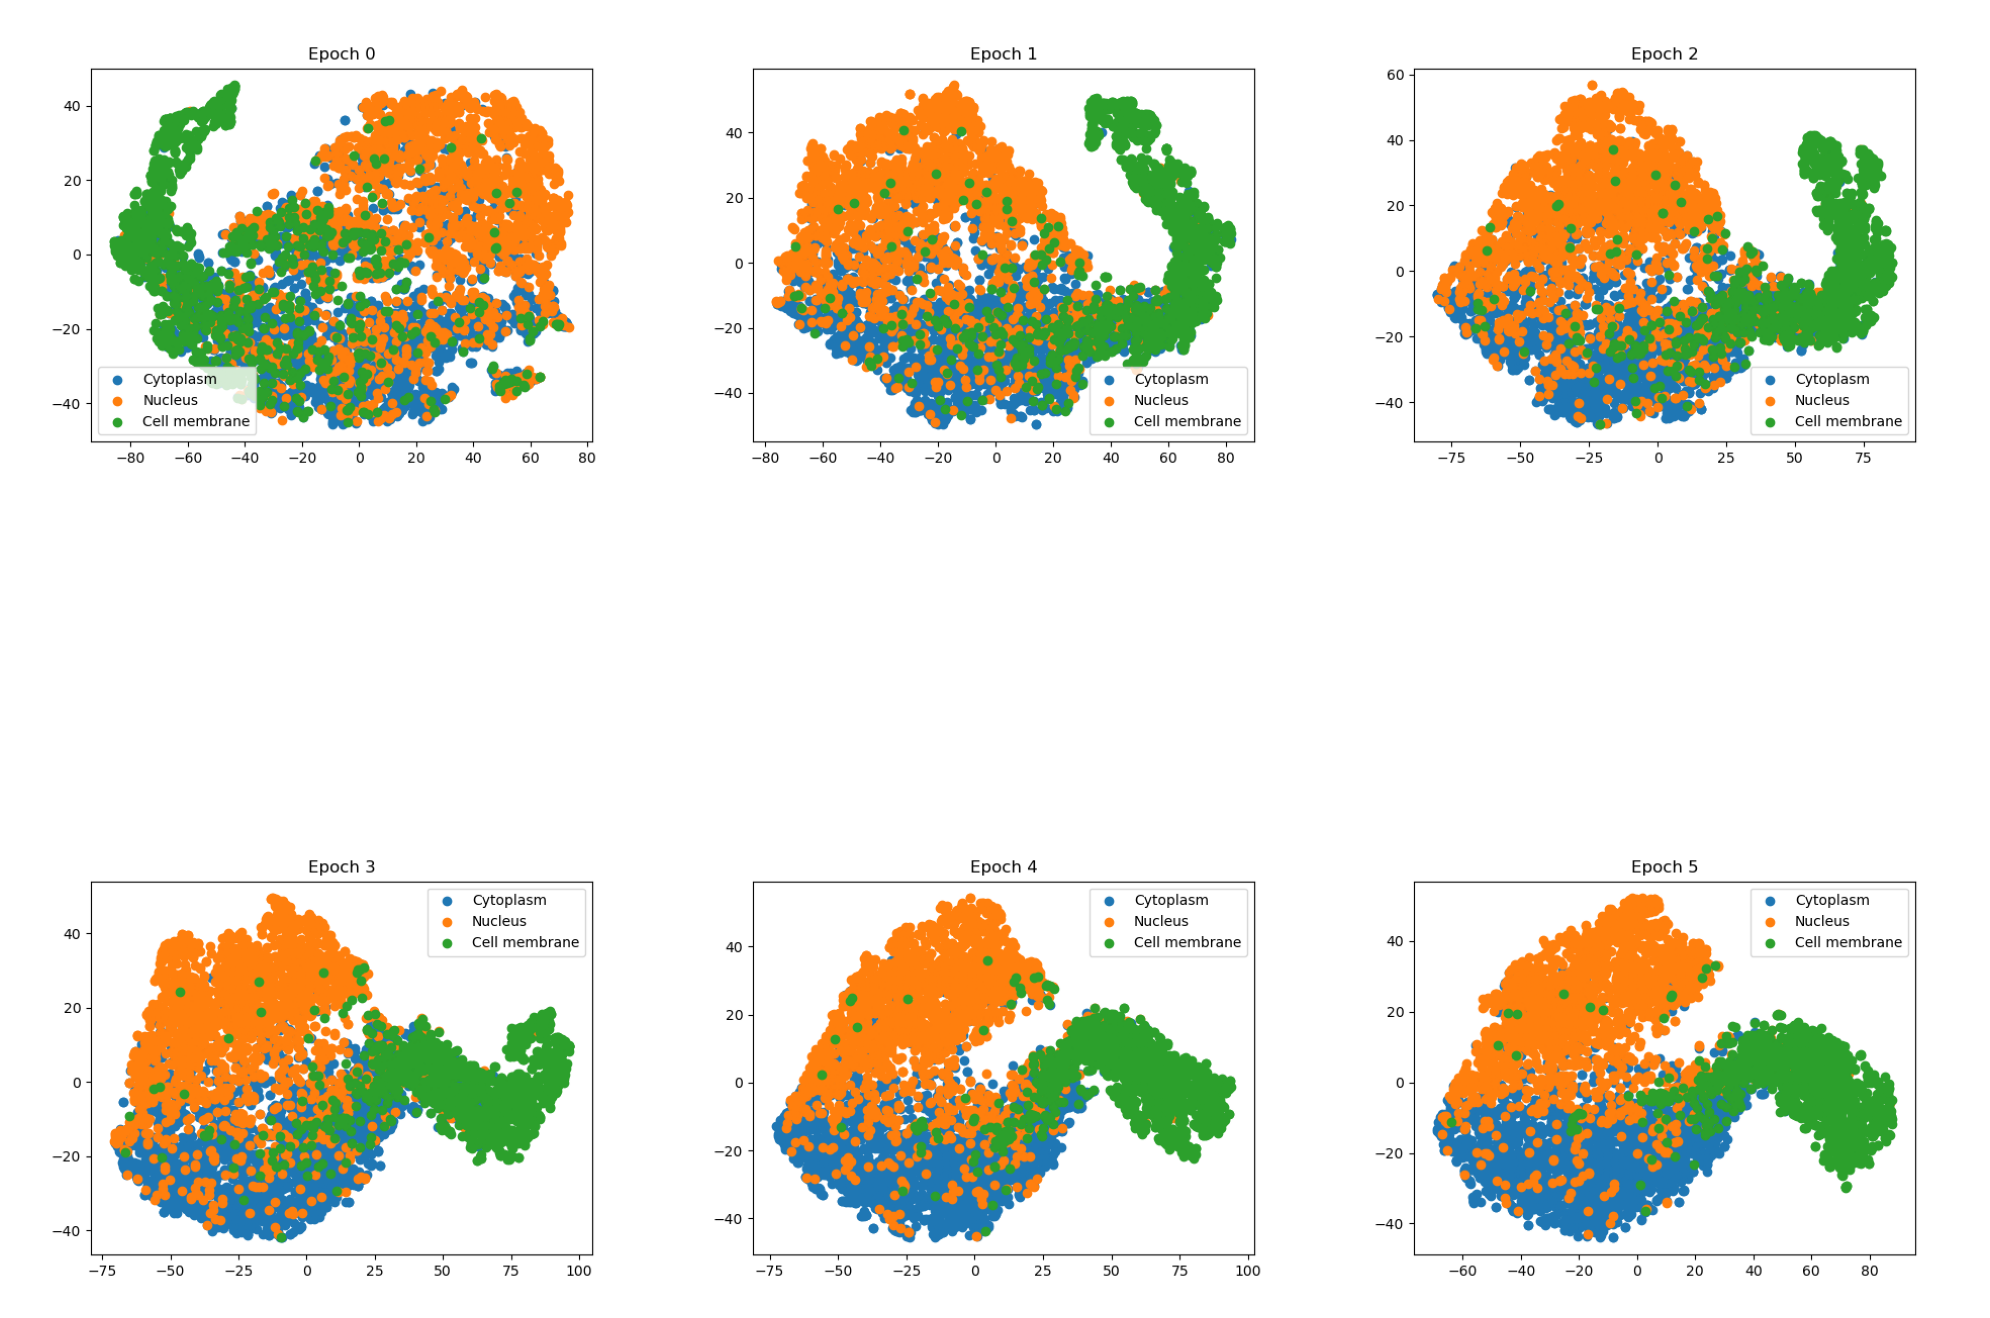

In [90]:
val_type = "train"
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/subloc/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

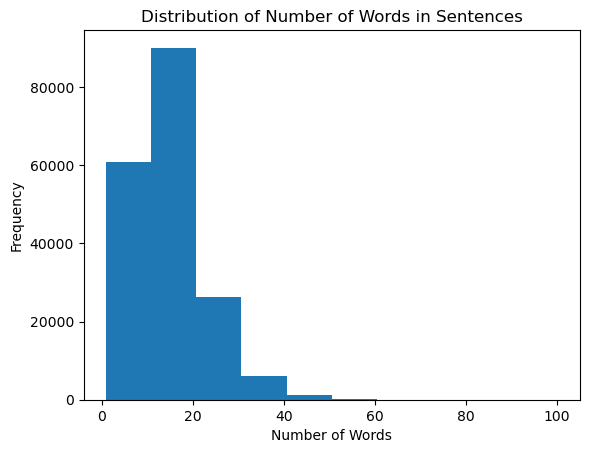

In [61]:

num_words_per_sentence =[]

for summary in genes["Summary"]:
    for sent in sent_tokenize(summary):
        num_words_per_sentence.append(len(sent.split()))
        

num_sent_per_sentence = [len(sent_tokenize(sentence)) for sentence in genes["Summary"]]

plt.hist(num_words_per_sentence)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words in Sentences')
plt.show()

# Pooling (mean):
- This pooling is for tokens in a sentence. BERT returns an embedding for each word(token) in a sentence. To get the entire sentence embedding, we perform pooling on tokens.

- To get the embedding for a list of sentences in a paragraph, a second pooling should be performed.

CAVEAT: The summaries were truncated to 512 tokens(app. 512 words).

In [7]:
pooled_embeddings= getSentenceEmbeddings(genes["Summary"].tolist(), pool="mean", batch_size=500)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform tokenization ...
Tokenization Done.
Get embeddings ...


100%|██████████| 33/33 [13:57<00:00, 25.38s/it]


torch.Size([16040, 768])


In [8]:
#%matplotlib notebook
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

tsne = TSNE(n_components=2)
scaler = StandardScaler()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    latents_tsne = tsne.fit_transform(pooled_embeddings.detach().numpy())

In [28]:
#np.save("data/tsne_embeddings.npy", latents_tsne)
#latents_tsne = np.load("data/tsne_embeddings.npy")

<IPython.core.display.Javascript object>


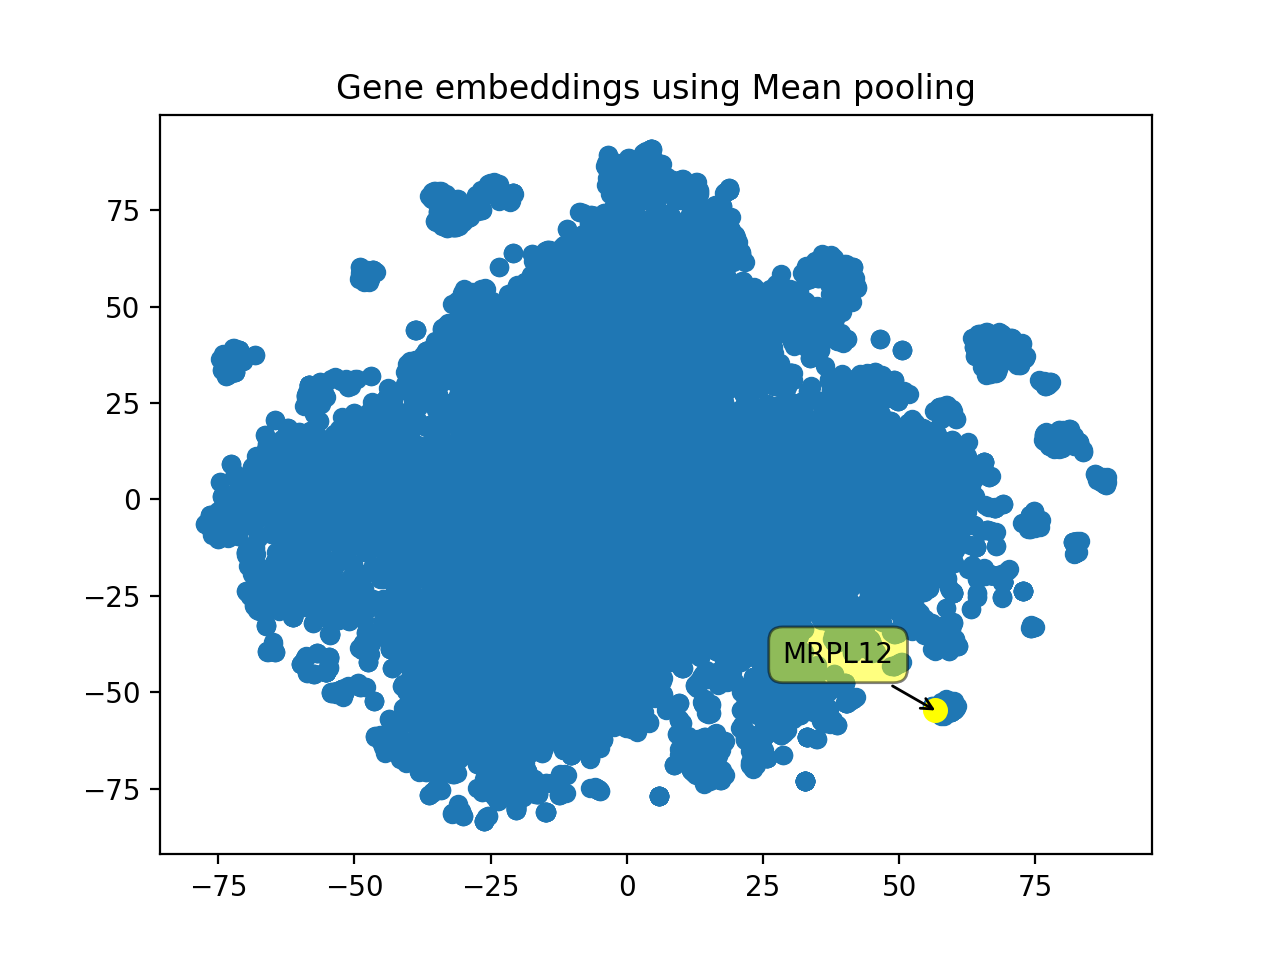

In [12]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.scatter(latents_tsne[:, 0], latents_tsne[:, 1])
ax.set_title('Gene embeddings using Mean pooling')
crs = mplcursors.cursor(ax,highlight=True)
crs.connect("add", lambda sel: sel.annotation.set_text(genes["Gene name"][sel.index]))

plt.show()

# Pooling (CLS):
- This pooling is for tokens in a sentence. BERT returns an embedding for each word(token) in a sentence. To get the entire sentence embedding, we perform pooling on tokens.

- To get the embedding for a list of sentences in a paragraph, a second pooling should be performed.

CAVEAT: The summaries were truncated to 512 tokens(app. 512 words).

In [21]:

pooled_embeddings= getSentenceEmbeddings(genes["Summary"].tolist(), pool="cls", batch_size=500)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform tokenization ...
Tokenization Done.
Get embeddings ...


100%|██████████| 33/33 [13:53<00:00, 25.27s/it]


torch.Size([16040, 768])


In [42]:
#filename = 'data/reconstructed_data.json'
# with open(filename, 'w') as file:
#     json.dump(dataset_reconstructed, file)

768

<IPython.core.display.Javascript object>


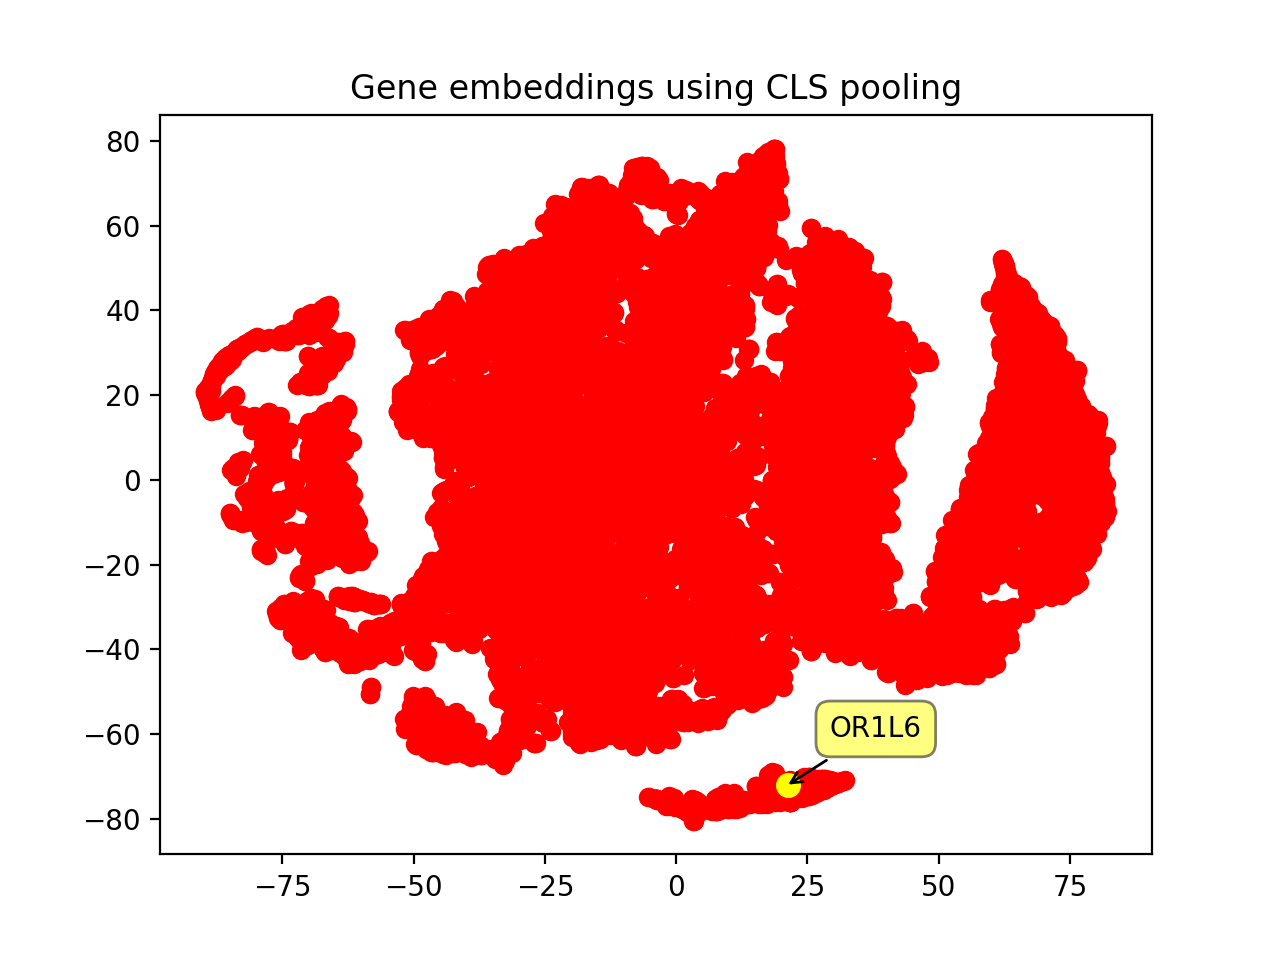

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    latents_tsne = tsne.fit_transform(pooled_embeddings.detach().numpy())
    
fig2, ax2 = plt.subplots()
ax2.scatter(latents_tsne[:, 0], latents_tsne[:, 1], color='red')
ax2.set_title('Gene embeddings using CLS pooling')
crs2 = mplcursors.cursor(ax2, highlight=True)
crs2.connect("add", lambda sel: sel.annotation.set_text(genes["Gene name"][sel.index]))

plt.show()

In [17]:
pooled_embeddings= getSentenceEmbeddings(genes["Summary"].tolist(), pool="max", batch_size=500)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform tokenization ...
Tokenization Done.
Get embeddings ...


100%|██████████| 33/33 [13:55<00:00, 25.31s/it]


torch.Size([16040, 768])


<IPython.core.display.Javascript object>


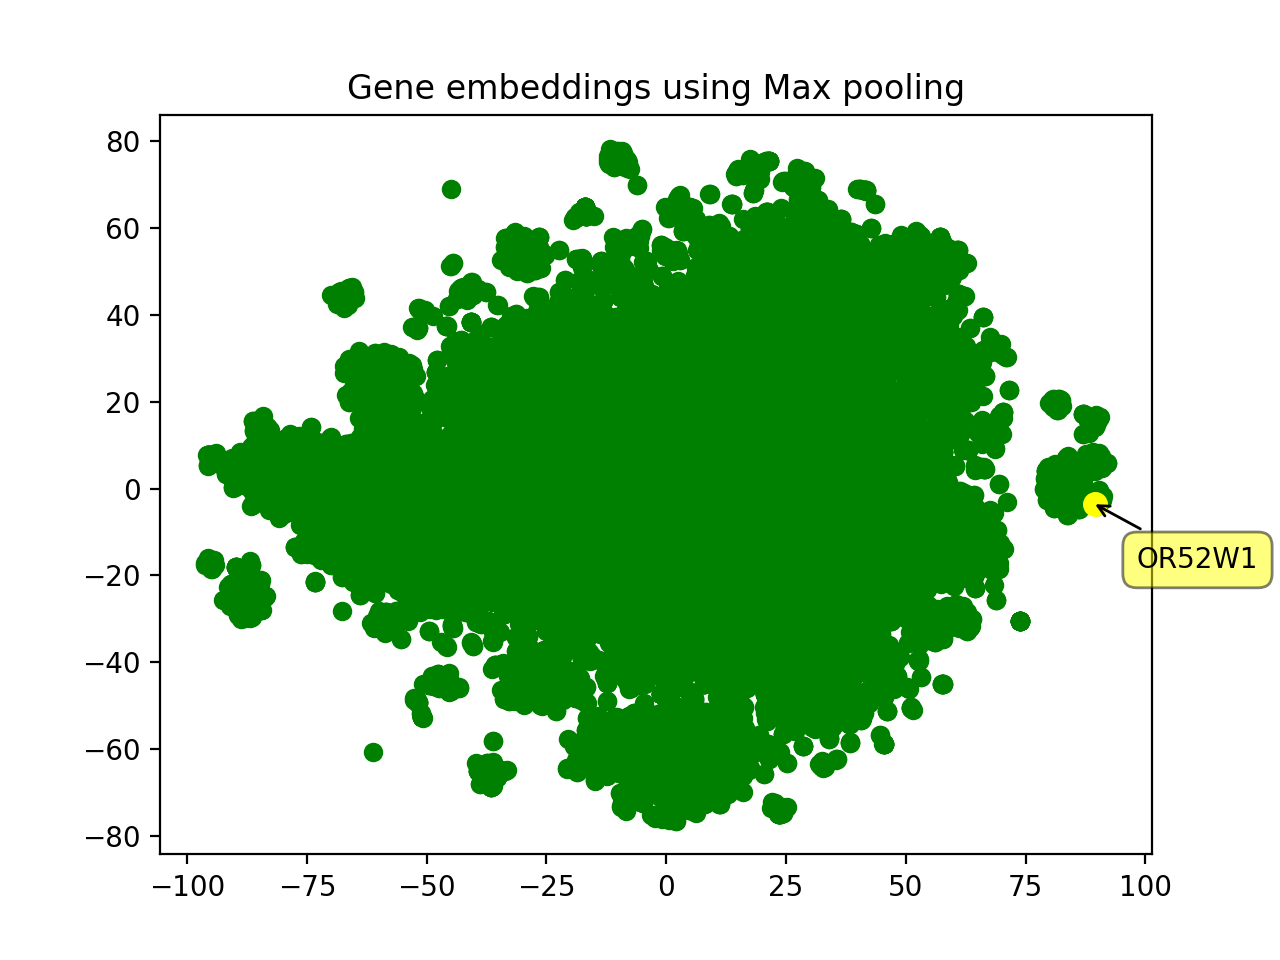

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    latents_tsne = tsne.fit_transform(pooled_embeddings.detach().numpy())
    
fig3, ax3 = plt.subplots()
ax3.scatter(latents_tsne[:, 0], latents_tsne[:, 1], color='green')
ax3.set_title('Gene embeddings using Max pooling')
crs3= mplcursors.cursor(ax3, highlight=True)
crs3.connect("add", lambda sel: sel.annotation.set_text(genes["Gene name"][sel.index]))

plt.show()

## Subcellular Locations

In [42]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight

# for i in range (20):
X = getSentenceEmbeddings(genes_loc["Summary"].tolist(), pool="cls", batch_size=500)
Y = genes_loc["Y"]

class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
class_weight_dict = {i: weight for i, weight in zip(np.unique(Y), class_weights)}

model = LogisticRegression(C=0.1, max_iter=1000, class_weight=class_weight_dict)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, Y, cv=skf)
print("Scores:", scores)
print("Mean Accuracy:", np.mean(scores))

Scores: [0.62157434 0.60874636 0.62215743 0.61166181 0.5991832 ]
Mean Accuracy: 0.612664627778099


In [187]:
import ast
import re

for i in range (len(df["Summary"])):
    
    sent = df["Summary"][i]
    pattern1 = r'(?:"(.*?)"|\'(.*?)\')'
    pattern2 = r"\[provided by .*?\]"
    pattern3 = r"\(PubMed:\d+(?:\s+\d+)*\)"
    pattern4 = r"\(\s+[\w\s]+\s+[\w]+\s+\)"
    pattern5 = r"\s*\(Microbial infection\)"
    pattern6 = r"\[(Isoform [^\]]+)\]:\s*"
    pattern7 = r"\(By similarity\)"

    matches = re.findall(pattern1, sent)
    captured_content = [match[0] if match[0] else match[1] for match in matches]
    sentences = " ".join(captured_content)
    sentences = re.sub(pattern2, "", sentences)
    sentences = re.sub(pattern3, "####", sentences)
    sentences = re.sub(pattern4, "", sentences)
    sentences = re.sub(pattern5, "", sentences)
    sentences = re.sub(pattern6, r"\1 ", sentences)
    sentences = re.sub(pattern7, "", sentences)
    sentences = re.sub(r'\s+', ' ', sentences)
    

    if len(sentences.split("                  "))>2:
        print(df["Gene name"][i])
        print(i)
        print(sentences)
        print("-"*60)
